In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [ ]:
import pandas as pd

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
from Bio.Seq import Seq
from Bio import SeqIO
import numpy as np
from rapidfuzz import process
import gzip
import glob

/content/drive/MyDrive/Colab Notebooks/Bio/__init__.py:126: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /content/drive/MyDrive/Colab Notebooks
  BiopythonWarning,


#Single bead mass prediction

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17'
# save to fastq
files = glob.glob((dir + "/*READ1-Sequences.txt.gz"))
for f in files:
  s = str(os.path.basename(f))
  print(s)
  s = s.replace('.txt.gz','')
  with gzip.open(f, "rt") as handle:
    records = (rec for rec in SeqIO.parse(handle, "fastq"))
    count = SeqIO.write(records, str(s +".fastq"), "fastq")
    print(count)# rename and re-write all files as fastq
  handle.close()





mR300-L1-P02-ATCACG-GATATCGA-READ1-Sequences.txt.gz
514
mR300-L1-P01-ATCACG-AGCGCTAG-READ1-Sequences.txt.gz
2132
mR300-L1-P03-ATCACG-CGCAGACG-READ1-Sequences.txt.gz
713
mR300-L1-P05-ATCACG-AGGTGCGT-READ1-Sequences.txt.gz
8523
mR300-L1-P04-ATCACG-TATGAGTA-READ1-Sequences.txt.gz
2739
mR300-L1-P06-ATCACG-GAACATAC-READ1-Sequences.txt.gz
2806
mR300-L1-P07-ATCACG-ACATAGCG-READ1-Sequences.txt.gz
905
mR300-L1-P10-ATCACG-TTGGTGAG-READ1-Sequences.txt.gz
4382
mR300-L1-P09-ATCACG-CCAACAGA-READ1-Sequences.txt.gz
109
mR300-L1-P08-ATCACG-GTGCGATA-READ1-Sequences.txt.gz
7625
mR300-L1-P11-ATCACG-CGCGGTTC-READ1-Sequences.txt.gz
751
mR300-L1-P12-ATCACG-TATAACCT-READ1-Sequences.txt.gz
6465
mR300-L1-P14-CGATGT-GATATCGA-READ1-Sequences.txt.gz
187
mR300-L1-P13-CGATGT-AGCGCTAG-READ1-Sequences.txt.gz
2759
mR300-L1-P15-CGATGT-CGCAGACG-READ1-Sequences.txt.gz
2372
mR300-L1-P16-CGATGT-TATGAGTA-READ1-Sequences.txt.gz
4110
mR300-L1-P17-CGATGT-AGGTGCGT-READ1-Sequences.txt.gz
83
mR300-L1-P19-CGATGT-ACATAGCG-READ1-Sequ

move files into the folder

read1


In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17'
files = glob.glob((dir + "/*READ1-Sequences.fastq"))
#print(files)
well_codes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ILBarcodes.csv')
master_df = pd.DataFrame(columns = ['Well ID', "Code"] )
decoding_table = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/6_Pos_Oligos_NGS_Fwd.csv')

# read in files. for each file,
for f in files:
  print(f)
  try:
    #get file name and all sequences in the file and filename
    s = str(os.path.basename(f))
    combo = s[13:28]
    print(combo)
    well = well_codes.loc[well_codes['barcode_combo_revcomp'] == combo]['Library Name'].values[0]
    print(well) #get well #

    reads = SeqIO.parse(f, "fastq")
    sequences = pd.DataFrame(columns = ["Seq"])
    for r in reads:
      sequences.loc[len(sequences)] = [str(r.seq)]
      #print(sequences)

    matches = pd.DataFrame(columns = ["Code", "UMI"])

    for i in sequences['Seq'].values:
      seq = str(i)
      index = seq.find('CAGCGAC') + len('CAGCGAC') + 1 # + 1 will skip the A in ATGG so we can compare all lengths at 11 nucelotides
      # chunk up codes into sequences
      if index != -1:
        add_list = [seq[index:index+11], #Pos 1
                  seq[index+11 :index + 22], # Pos 2
                  seq[index + 22 : index + 33], #Pos 3
                  seq[index + 33 : index + 44],#Pos 4
                  seq[index + 44 : index + 55], #Pos 5
                  seq[index + 55 : index + 66], # Pos 6
                  seq[index + 77 : index + 85] # UMI
                    ]
      # now get position codes for each sequence chunk
      code_list = [] #list to hold code matches
      for s in add_list:
        best = process.extractOne(str(s), decoding_table['Sequences'], score_cutoff = 85)
        #print(best)
        if best:#if match was found
          oligo_code = decoding_table.loc[decoding_table['Sequences'] == str(best[0])]['Tag'].item()
          # print(best)
          #print(oligo_code)
          code_list.append(oligo_code)
    # print(len(code_list))
      if len(code_list) == 6: #only add full length reads
        matches.loc[len(matches)] = [code_list, add_list[6]]
      #print(matches)
    matches.to_csv('tempdf.csv')
    matches = pd.read_csv('tempdf.csv')
    matches2 = pd.DataFrame(matches.groupby('Code')['UMI'].nunique())
    matches = matches2.sort_values(by=['UMI'], ascending=False).reset_index()#sort so that values with the most UMI counts are at the top, then only take the top read
    print(well, matches['Code'].iloc[0])
    master_df.loc[len(master_df)] = [well, matches['Code'].iloc[0]]
  except:
    continue


/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17/mR300-L1-P02-ATCACG-GATATCGA-READ1-Sequences.fastq
ATCACG-GATATCGA
P1A2
P1A2 [1153, 2256, 1355, 2409, 1511, 2617]
/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17/mR300-L1-P01-ATCACG-AGCGCTAG-READ1-Sequences.fastq
ATCACG-AGCGCTAG
P1A1
P1A1 [1152, 2249, 1349, 2409, 1524, 2617]
/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17/mR300-L1-P03-ATCACG-CGCAGACG-READ1-Sequences.fastq
ATCACG-CGCAGACG
P1A3
P1A3 [1126, 2202, 1326, 2411, 1512, 2645]
/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17/mR300-L1-P05-ATCACG-AGGTGCGT-READ1-Sequences.fastq
ATCACG-AGGTGCGT
P1A5
P1A5 [1129, 2205, 1341, 2410, 1522, 2622]
/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17/mR300-L1-P04-ATCACG-TATGAGTA-READ1-Sequences.fastq
ATCACG-TATGAGTA
P1A4
P1A4 [1146, 2222, 1310, 2416, 1527, 2601]
/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17/mR300-L1-P06-ATCACG-GAACATAC-READ1-Sequences.fastq
ATCACG-GAACATAC
P1A6
P1A6

read2

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17'
files = glob.glob((dir + "/*READ2-Sequences.fastq"))
#print(files)
well_codes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ILBarcodes.csv')
master_df = pd.DataFrame(columns = ['Well ID', "Code"] )
decoding_table = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/6_Pos_Oligos_NGS_Fwd.csv')

# read in files. for each file,
for f in files:
  print(f)
  try:
    #get file name and all sequences in the file and filename
    s = str(os.path.basename(f))
    combo = s[13:28]
    print(combo)
    well = well_codes.loc[well_codes['barcode_combo_revcomp'] == combo]['Library Name'].values[0]
    print(well) #get well #

    reads = SeqIO.parse(f, "fastq")
    sequences = pd.DataFrame(columns = ["Seq"])
    for r in reads:
      sequences.loc[len(sequences)] = [str(r.reverse_complement().seq)]
      #print(sequences)

    matches = pd.DataFrame(columns = ["Code", "UMI"])

    for i in sequences['Seq'].values:
      seq = str(i)
      index = seq.find('CAGCGAC') + len('CAGCGAC') + 1 # + 1 will skip the A in ATGG so we can compare all lengths at 11 nucelotides
      # chunk up codes into sequences
      if index != -1:
        add_list = [seq[index:index+11], #Pos 1
                  seq[index+11 :index + 22], # Pos 2
                  seq[index + 22 : index + 33], #Pos 3
                  seq[index + 33 : index + 44],#Pos 4
                  seq[index + 44 : index + 55], #Pos 5
                  seq[index + 55 : index + 66], # Pos 6
                  seq[index + 77 : index + 85] # UMI
                    ]
      # now get position codes for each sequence chunk
      code_list = [] #list to hold code matches
      for s in add_list:
        best = process.extractOne(str(s), decoding_table['Sequences'], score_cutoff = 78)
        #print(best)
        if best:#if match was found
          oligo_code = decoding_table.loc[decoding_table['Sequences'] == str(best[0])]['Tag'].item()
          # print(best)
          #print(oligo_code)
          code_list.append(oligo_code)
    # print(len(code_list))
      if len(code_list) == 6: #only add full length reads
        matches.loc[len(matches)] = [code_list, add_list[6]]
      #print(matches)
    matches.to_csv('tempdf.csv')
    matches = pd.read_csv('tempdf.csv')
    matches2 = pd.DataFrame(matches.groupby('Code')['UMI'].nunique())
    matches = matches2.sort_values(by=['UMI'], ascending=False).reset_index()#sort so that values with the most UMI counts are at the top, then only take the top read
    print(well, matches['Code'].iloc[0])
    master_df.loc[len(master_df)] = [well, matches['Code'].iloc[0]]
  except:
    continue


In [ ]:
master_df.to_csv('NGS_SINGLBEAD_DEl17_r1_mm1.csv')
print(master_df)

   Well ID                                  Code
0     P1A2  [1153, 2256, 1355, 2409, 1511, 2617]
1     P1A1  [1152, 2249, 1349, 2409, 1524, 2617]
2     P1A3  [1126, 2202, 1326, 2411, 1512, 2645]
3     P1A5  [1129, 2205, 1341, 2410, 1522, 2622]
4     P1A4  [1146, 2222, 1310, 2416, 1527, 2601]
5     P1A6  [1111, 2211, 1347, 2402, 1504, 2623]
6     P1A7  [1147, 2211, 1323, 2412, 1511, 2629]
7    P1A10  [1104, 2204, 1304, 2401, 1503, 2624]
8     P1A9  [1153, 2254, 1353, 2416, 1527, 2609]
9     P1A8  [1120, 2244, 1332, 2427, 1514, 2606]
10   P1A11  [1153, 2253, 1355, 2407, 1507, 2611]
11   P1A12  [1101, 2213, 1325, 2401, 1514, 2606]
12    P1B2  [1118, 2206, 1318, 2412, 1512, 2622]
13    P1B1  [1109, 2245, 1321, 2411, 1512, 2628]
14    P1B3  [1156, 2255, 1353, 2403, 1516, 2616]
15    P1B4  [1111, 2235, 1347, 2413, 1540, 2612]
16    P1B5  [1101, 2201, 1301, 2412, 1510, 2632]
17    P1B7  [1125, 2201, 1313, 2403, 1514, 2613]
18    P1B6  [1116, 2216, 1304, 2406, 1517, 2611]
19    P1B8  [1128, 2

# 2 cycle DEL

In [ ]:
#df = pd.read_csv("collapsed_reads_groupedUMI.csv", dtype = str)
#df['Code'] = df['Code'].apply(eval)
master_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NGS_SINGLBEAD_DEl17_r1_mm1.csv')
print(master_df)
master_df['Code'] = master_df['Code'].apply(eval)

codes = pd.read_csv("Coding Scheme_20221020.csv")
#print(codes['code 1'])
new_df = pd.DataFrame(columns = ['Well','Total MW', 'Observed MW',
                                 'BB Code 1', 'BB Code 1 MW', "BB Code 1 SMILES",
                                 'BB Code 2', 'BB Code 2 MW',"BB Code 2 SMILES",
                                 'C1 Truncate'])

for i, entry in enumerate(master_df['Code'].values):

  pos1 = entry[0]
  pos2 = entry[1]
  pos3 = entry[2]
  pos4 = entry[3]
  pos5 = entry[4]

  code1 = str(pos1) + " - " + str(pos2) + " - " + str(pos3)
  code2 = str(pos4) + "-" + str(pos5)

  bb1 = codes[codes.eq(code1).any(1)]['BB Code'].values
  w1 = codes[codes.eq(code1).any(1)]['Coupled mass - Fmoc'].values
  s1 = codes[codes.eq(code1).any(1)]['SMILES'].values
  bb2 = codes[codes.eq(code2).any(1)]['BB Code'].values
  w2 = codes[codes.eq(code2).any(1)]['MW'].values
  s2 = codes[codes.eq(code2).any(1)]['SMILES'].values
  if bb1 != "" and bb2 != "": #only reads with full length matches will continue now.
    print(bb1,bb2)
    w1 = float(w1)
    w2 = float(w2)
    #print(new_df)
    new_df.loc[len(new_df)] = [master_df.iloc[i]['Well ID'],(w1+ w2 -18), None,
                               bb1, w1, s1,
                               bb2, w2, s2,
                               w1]
    print([master_df.iloc[i]['Well ID'],(w1+ w2 -18), None,
                               bb1, w1, s1,
                               bb2, w2, s2,
                               w1])

print(new_df)
new_df.to_csv("decode_202201114_mm2ß.csv")

    Unnamed: 0 Well ID                                  Code
0            0    P1A2  [1153, 2256, 1355, 2409, 1511, 2617]
1            1    P1A1  [1152, 2249, 1349, 2409, 1524, 2617]
2            2    P1A3  [1126, 2202, 1326, 2411, 1512, 2645]
3            3    P1A5  [1129, 2205, 1341, 2410, 1522, 2622]
4            4    P1A4  [1146, 2222, 1310, 2416, 1527, 2601]
5            5    P1A6  [1111, 2211, 1347, 2402, 1504, 2623]
6            6    P1A7  [1147, 2211, 1323, 2412, 1511, 2629]
7            7   P1A10  [1104, 2204, 1304, 2401, 1503, 2624]
8            8    P1A9  [1153, 2254, 1353, 2416, 1527, 2609]
9            9    P1A8  [1120, 2244, 1332, 2427, 1514, 2606]
10          10   P1A11  [1153, 2253, 1355, 2407, 1507, 2611]
11          11   P1A12  [1101, 2213, 1325, 2401, 1514, 2606]
12          12    P1B2  [1118, 2206, 1318, 2412, 1512, 2622]
13          13    P1B1  [1109, 2245, 1321, 2411, 1512, 2628]
14          14    P1B3  [1156, 2255, 1353, 2403, 1516, 2616]
15          15    P1B4  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


     Well     Total MW Observed MW  BB Code 1  BB Code 1 MW  \
0    P1A2  1457.991730        None  [ST-1681]   1299.908000   
1    P1A1  1466.711676        None  [ST-2818]   1318.637448   
2    P1A3  1439.664392        None  [ST-1402]   1278.631300   
3    P1A5  1434.612220        None  [ST-1675]   1288.615650   
4    P1A4  1474.645820        None   [ST-820]   1299.571926   
5    P1A6  1399.604099        None   [ST-821]   1260.584350   
6    P1A7  1436.642260        None   [ST-821]   1260.584350   
7   P1A10  1510.682205        None  [ST-1674]   1329.642199   
8    P1A9  1474.981894        None  [ST-1681]   1299.908000   
9    P1A8  1489.741579        None  [ST-1680]   1328.646950   
10  P1A11  1439.977143        None  [ST-1681]   1299.908000   
11  P1A12  1414.813561        None  [ST-1401]   1237.788000   
12   P1B2  1485.710279        None  [ST-1676]   1328.646950   
13   P1B1  1489.680042        None  [ST-1682]   1328.646950   
14   P1B3  1466.956822        None  [ST-1681]   1299.90

#3 Cycle DEL

In [ ]:
#df = pd.read_csv("collapsed_reads_groupedUMI.csv", dtype = str)
#df['Code'] = df['Code'].apply(eval)
master_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220719_master_decodes_SBC.csv')
print(master_df)
master_df['Code'] = master_df['Code'].apply(eval)

codes = pd.read_csv("Plate layouts and decoding del16.3.csv")
#print(codes['code 1'])
new_df = pd.DataFrame(columns = ['Well','Total MW', 'Observed MW',
                                 'BB Code 1', 'BB Code 1 MW', "BB Code 1 SMILES",
                                 'BB Code 2', 'BB Code 2 MW',"BB Code 2 SMILES",
                                 'BB Code 3', 'BB Code 3 MW', "BB Code 3 SMILES",
                                 "C1+C2 Truncate MW",
                                 'C1 + C3 Truncate MW',
                                 'C2 + C3 Truncate MW',
                                 'C1 Truncate'])

for i, entry in enumerate(master_df['Code'].values):

  pos1 = entry[0]
  pos2 = entry[1]
  pos3 = entry[2]
  pos4 = entry[3]
  pos5 = entry[4]

  code1 = str(pos1)
  code2 = str(pos2) + " - " + str(pos3)
  code3 = str(pos4) + " - " + str(pos5)

  bb1 = codes[codes.eq(code1).any(1)]['Name'].values
  w1 = codes[codes.eq(code1).any(1)]['MW'].values
  s1 = codes[codes.eq(code1).any(1)]['SMILES'].values
  bb2 = codes[codes.eq(code2).any(1)]['Name'].values
  w2 = codes[codes.eq(code2).any(1)]['MW'].values
  s2 = codes[codes.eq(code2).any(1)]['SMILES'].values
  bb3 = codes[codes.eq(code3).any(1)]['Name'].values
  w3=  codes[codes.eq(code3).any(1)]['MW'].values
  s3 = codes[codes.eq(code3).any(1)]['SMILES'].values
  if bb1 != "" and bb2 != "" and bb3 != "": #only reads with full length matches will continue now.
    #print(bb1,bb2,bb3)
    #print(new_df)
    new_df.loc[len(new_df)] = [master_df.iloc[i]['Well ID'],(sum(w1+ w2 + w3)- 31.7), None,
                               bb1, w1, s1,
                               bb2, w2, s2,
                               bb3, w3, s3,
                               sum(w1 + w2) - 14.5,
                               sum(w1+w3) - 17.5,
                               sum(w2 + w3),
                               sum(w1)]
    print([master_df.iloc[i]['Well ID'],(sum(w1+ w2 + w3)- 31.7), None,
                               bb1, w1, s1,
                               bb2, w2, s2,
                               bb3, w3, s3,
                               sum(w1 + w2) - 14.5,
                               sum(w1+w3) - 17.5,
                               sum(w2 + w3),
                               sum(w1)])

print(new_df)
new_df.to_csv("decode_20220719.csv")

     Unnamed: 0 Well ID                                  Code
0             0    P1A4  [1107, 2211, 1326, 2405, 1507, 2629]
1             1    P1A3  [1122, 2222, 1315, 2441, 1512, 2623]
2             2    P1A5  [1115, 2228, 1346, 2442, 1524, 2634]
3             3    P1A6  [1124, 2220, 1339, 2429, 1510, 2617]
4             4    P1A7  [1104, 2225, 1310, 2426, 1516, 2624]
..          ...     ...                                   ...
160         160    P2G9  [1131, 2235, 1335, 2426, 1522, 2643]
161         161    P2G8  [1124, 2236, 1341, 2409, 1502, 2639]
162         162   P2G12  [1116, 2204, 1337, 2422, 1521, 2638]
163         163    P1A1  [1135, 2207, 1325, 2435, 1529, 2628]
164         164    P1A2  [1119, 2206, 1313, 2441, 1506, 2615]

[165 rows x 3 columns]
['P1A4', 1485.643133, None, array(['DA-31'], dtype=object), array([1089.115698]), array(['CC1NCCNC1C'], dtype=object), array(['AA-60'], dtype=object), array([188.162709]), array(['OC([C@@H](C(C1)Cc2c1cccc2)NC(OCC1c(cccc2)c2-c2c1cccc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


['P1B4', 1356.574051, None, array(['DA-28'], dtype=object), array([1075.100048]), array(['C[C@@H]1NCCNC1'], dtype=object), array(['AA-67'], dtype=object), array([148.131409]), array(['OC([C@H](c1ccccc1)NC(OCC1c(cccc2)c2-c2c1cccc2)=O)=O'],
      dtype=object), array(['CA-51'], dtype=object), array([165.042594]), array(['NC(c(cc1)ccc1C(O)=O)=O'], dtype=object), 1208.731457, 1222.642642, 313.17400299999997, 1075.100048]
['P1B5', 1356.574051, None, array(['DA-28'], dtype=object), array([1075.100048]), array(['C[C@@H]1NCCNC1'], dtype=object), array(['AA-67'], dtype=object), array([148.131409]), array(['OC([C@H](c1ccccc1)NC(OCC1c(cccc2)c2-c2c1cccc2)=O)=O'],
      dtype=object), array(['CA-51'], dtype=object), array([165.042594]), array(['NC(c(cc1)ccc1C(O)=O)=O'], dtype=object), 1208.731457, 1222.642642, 313.17400299999997, 1075.100048]
['P1B8', 1356.574051, None, array(['DA-28'], dtype=object), array([1075.100048]), array(['C[C@@H]1NCCNC1'], dtype=object), array(['AA-67'], dtype=object), arr

# prepping files for ML by adding in properties

In [ ]:
# Clean up file

df = pd.read_csv('decode_20220719.csv',dtype = str)
df= df.replace('\[\'', '', regex = True)
df= df.replace('\'\]', '', regex = True)
df= df.replace('\[', '', regex = True)
df= df.replace('\]', '', regex = True)
df.to_csv('SBC decode_file_20220719_cleaned.csv')
print(df)



    Unnamed: 0   Well     Total MW Observed MW BB Code 1 BB Code 1 MW  \
0            0   P1A4  1485.643133         NaN     DA-31  1089.115698   
1            1   P1A3  1465.716025         NaN     DA-36  1075.168128   
2            2   P1A5  1412.600266         NaN     DA-27  1087.100048   
3            3   P1A6  1442.624766         NaN     DA-40  1061.152478   
4            4   P1A7  1376.580279         NaN     DA-28  1075.100048   
..         ...    ...          ...         ...       ...          ...   
156        156   P2G9  1412.582506         NaN     DA-31  1089.115698   
157        157   P2G8  1380.653364         NaN     DA-40  1061.152478   
158        158  P2G12  1462.511755         NaN     DA-28  1075.100048   
159        159   P1A1  1354.626481         NaN     DA-38  1075.168128   
160        160   P1A2  1453.547806         NaN     DA-31  1089.115698   

                              BB Code 1 SMILES BB Code 2 BB Code 2 MW  \
0                                   CC1NCCNC1C    

In [ ]:
# refomat decode sheet so each BB has a unique code/bead
import itertools
df = pd.read_csv('SBC decode_file_20220719_cleaned.csv',dtype = str, header = 0)
properties = pd.read_csv('BB properties_16.3.csv',dtype = str, header = 0)
old_cols = properties.columns.values
col_list = ["Bead No", "BB","BBSMILES"]

for i in old_cols:
  col_list.append(i)
col_list.append("Match?")
print(col_list)

new_df = pd.DataFrame(columns = col_list)
# new_df = new_df.reindex(list(zip(["Bead No"], ["BB"],["BBSMILES"], old_cols, ["Match?"])))
# print(new_df)


for index, row in df.iterrows():
  c1BB = row['BB Code 1']
  c2BB = row['BB Code 2']
  c3BB = row['BB Code 3']

  c1Prop = [i for i in properties.loc[properties['Name'] == c1BB].iloc[0]]

  c2Prop = [i for i in properties.loc[properties['Name'] == c2BB].iloc[0]]

  c3Prop = [i for i in properties.loc[properties['Name'] == c3BB].iloc[0]]

  # Write in matches for c1 BB's
  if row['Match'] == 'c1' or row['Match'] =='c1+c2' or row['Match'] =='c1+c3' or row['Match'] =='c1+c2,c1+c3' or row['Match'] =='Full':
    add_row = list(itertools.chain([row['Bead No']], [c1BB] ,[row['BB Code 1 SMILES']], c1Prop, ['1']))
    print(row['Match'])
    new_df.loc[len(new_df)] = add_row
  else:
    add_row = list(itertools.chain([row['Bead No']], [c1BB] ,[row['BB Code 1 SMILES']], c1Prop, ['0']))
    new_df.loc[len(new_df)] = add_row
  # Write in matches for c2 BB's
  if row['Match'] == 'c1+c2' or row['Match'] =='c2+c3'or row['Match'] =='Full':
    add_row = list(itertools.chain([row['Bead No']], [c2BB] ,[row['BB Code 2 SMILES']], c2Prop, ['1']))
    print(row['Match'])
    new_df.loc[len(new_df)] = add_row
  else:
    add_row = list(itertools.chain([row['Bead No']], [c2BB] ,[row['BB Code 2 SMILES']], c2Prop, ['0']))
    new_df.loc[len(new_df)] = add_row
# Write in matches for c3 BB's
  if row['Match'] == 'c1+c3' or row['Match'] =='c2+c3'or row['Match'] =='Full':
    add_row = list(itertools.chain([row['Bead No']], [c3BB] ,[row['BB Code 3 SMILES']], c3Prop, ['1']))
    print(row['Match'])
    new_df.loc[len(new_df)] = add_row
  else:
    add_row = list(itertools.chain([row['Bead No']], [c3BB] ,[row['BB Code 3 SMILES']], c3Prop, ['0']))
    new_df.loc[len(new_df)] = add_row


print(new_df)
new_df.to_csv('SBC decode file_20220719_PropsbyBB.csv')






['Bead No', 'BB', 'BBSMILES', 'Name', 'Structure of SMILES [idcode]', 'SMILES', 'Column 1', 'code 1', 'code 2', 'code 3', 'code 4', 'MW', 'Column 2', 'Column 3', 'Stereo Configuration', 'Total Molweight', 'Monoisotopic Mass', 'cLogP', 'cLogS', 'H-Acceptors', 'H-Donors', 'Total Surface Area', 'Relative PSA', 'Polar Surface Area', 'Druglikeness', 'Shape Index', 'Molecular Flexibility', 'Molecular Complexity', 'Fragments', 'Non-H Atoms', 'Non-C/H Atoms', 'Metal-Atoms', 'Electronegative Atoms', 'Stereo Centers', 'Rotatable Bonds', 'Rings Closures', 'Aromatic Atoms', 'sp3-Atoms', 'Symmetric atoms', 'Small Rings', 'Carbo-Rings', 'Hetero-Rings', 'Saturated Rings', 'Non-Aromatic Rings', 'Aromatic Rings', 'Saturated Carbo-Rings', 'Non-Aromatic Carbo-Rings', 'Carbo-Aromatic Rings', 'Saturated Hetero-Rings', 'Non-Aromatic Hetero-Rings', 'Hetero-Aromatic Rings', 'Amides', 'Amines', 'Alkyl-Amines', 'Aromatic Amines', 'Aromatic Nitrogens', 'Basic Nitrogens', 'Acidic Oxygens', 'Unnamed: 55', 'Globula

KeyError: ignored

#Machine learning

In [ ]:
import os
import sys
nb_path = '/content/drive/MyDrive/Colab\ Notebooks'
if nb_path not in sys.path:
  sys.path.insert(5, nb_path)
#os.symlink('/content/notebooks', nb_path)
os.chdir("/content/drive/MyDrive/Colab Notebooks")
!pip install --target=$nb_path sklearn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 1.7 MB/s 
     |████████████████████████████████| 15.7 MB 46.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.7 MB/s 
     |████████████████████████████████| 306 kB 43.3 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=48ec734026046274ec7c1f5a0dfc4404b1d785f480580c1e5bc3f26fc0c72022
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.6 MB/s 


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


#SVM without PCA

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [ ]:

df = pd.read_csv('master HTP SBC decode file_PropsbyBB_20220527.csv')
print(df.iloc[0:, 16:63])
kerneltype = 'sigmoid'
X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63], df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.fit_transform(X_test)


clf1 = SVC(kernel=kerneltype)
# print(X_train)
# print(X_test)
clf1.fit(X_train_norm, y_train)
predictions = clf1.predict(X_test_norm)
# print(y_test)
# print(predictions)
percentage = clf1.score(X_test_norm, y_test)
from sklearn.metrics import confusion_matrix
res = confusion_matrix(y_test, predictions)
print("Confusion Matrix")
print(res)
print(f"Test Set: {len(X_test_norm)}")
print(f"Accuracy = {percentage*100} %")

     Total Molweight  Monoisotopic Mass   cLogP  cLogS  H-Acceptors  H-Donors  \
0            373.407         373.131409  3.0434 -5.219            5         2   
1            421.879         421.108086  4.1521 -6.374            5         2   
2            421.879         421.108086  4.1521 -6.374            5         2   
3            388.422         388.142308  2.5452 -4.843            6         2   
4            433.459         433.152539  3.0138 -4.808            7         2   
..               ...                ...     ...    ...          ...       ...   
828          393.462         393.103479  3.4127 -5.648            5         2   
829          188.186         188.058578  0.8425 -2.004            4         2   
830          114.191         114.115698  0.0597 -0.587            2         2   
831          413.472         413.162709  3.8707 -6.117            5         2   
832          120.172         120.024500  0.5425 -1.656            2         1   

     Total Surface Area  Re

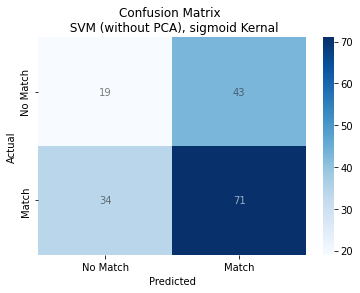

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predictions)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n SVM (without PCA), %s Kernal' % kerneltype);
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_SVMnoPCA%sDegree10_PCPs.svg" % kerneltype)

[[-2.57250963e-04  4.24719088e-02 -5.05201103e-01  1.15385537e-01
  -1.04443274e+00 -5.00777169e-02  3.25015669e-02  8.69465547e-04
  -2.46946856e-02  4.00055753e-02 -6.98057260e-01 -4.98420796e-01
  -7.06481436e-01  1.60464256e-02  3.53434944e-01 -5.80277908e-02
   0.00000000e+00 -5.80277908e-02  1.02574879e-01  5.17251140e-01
   1.95044001e-01 -3.08013394e-02 -3.02362074e-01 -3.64784999e-02
   1.95044001e-01  1.40438510e-01  5.46054907e-02 -3.37181753e-01
   2.27696156e-01 -3.26521551e-02  0.00000000e+00  5.64877909e-01
  -4.24439399e-01 -3.37181753e-01 -3.37181753e-01  3.91787244e-01
   2.04433175e+00  2.68236477e-02  1.02682365e+00 -1.00000000e+00
   3.25866273e-01  2.68236477e-02 -4.10334276e-01  3.47772139e-01
   4.29736014e-02 -3.23532270e-02 -5.39035929e-02]]


KeyboardInterrupt: ignored

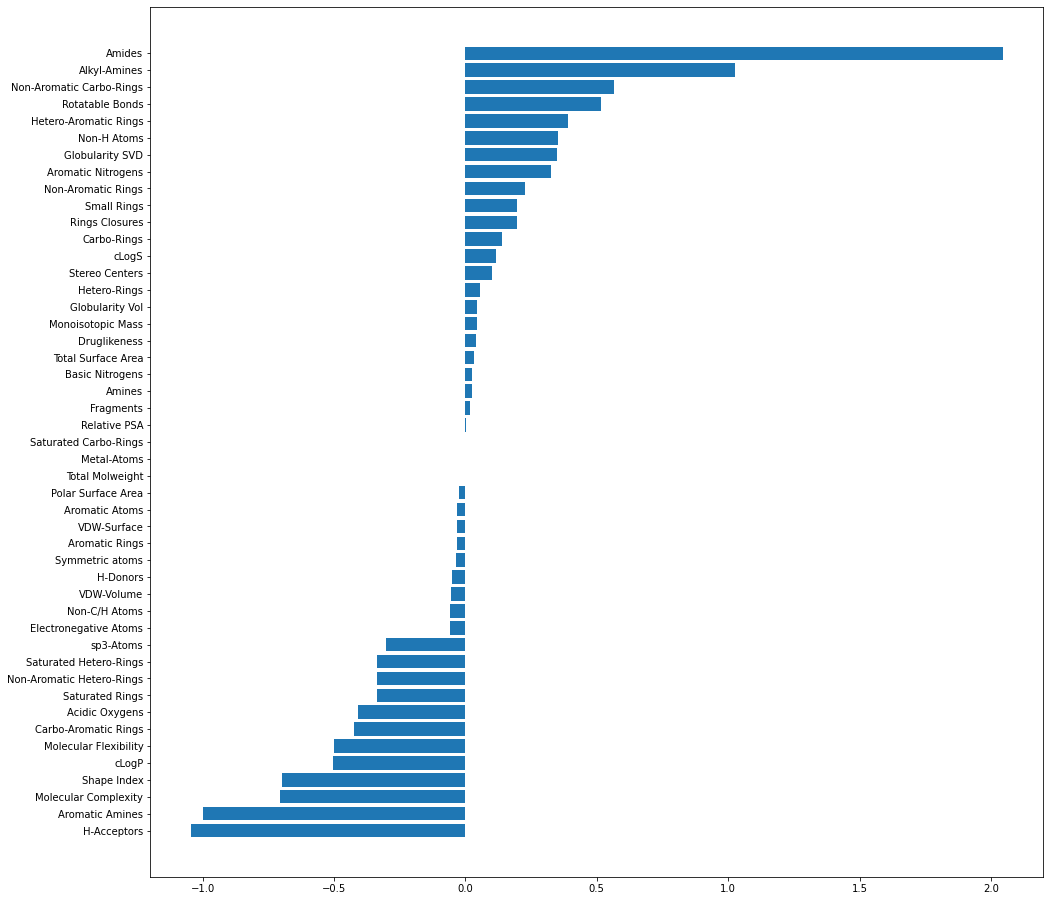

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(16,16))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.savefig("Barplot features_SVMnoPCA.svg")
    plt.show()
features_names = X_train.columns
print(clf1.coef_)
f_importances(clf1.coef_[0], features_names)

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(y)

# Binarize the output
lb = LabelBinarizer()
label = lb.fit_transform(y)
#label = np.hstack((label, 1 - label))
n_classes = label.shape[1]
print(label)
print(n_classes)

In [ ]:
y = np.array(df['Match?'])

# Binarize the output
lb = LabelBinarizer()
label = lb.fit_transform(y)
label = np.hstack((label, 1 - label))
n_classes = label.shape[1]
print(y)
print(label)
print(n_classes)


X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63], label, test_size= 0.2, random_state = 1 )



classifier_SVC = OneVsRestClassifier(
    SVC(kernel="linear", probability=True, random_state=1)
)
y_score = classifier_SVC.fit(X_train, y_train).decision_function(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf1, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.show()

# SVM with PCA

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


     Total Molweight  Monoisotopic Mass   cLogP  cLogS  H-Acceptors  H-Donors  \
0            112.175         112.100048 -0.3176 -0.506            2         2   
1            401.461         401.162709  3.8900 -5.982            5         2   
2            166.175         166.062995  1.4186 -1.991            3         1   
3            114.191         114.115698  0.0864 -0.856            2         2   
4            401.461         401.162709  3.8900 -5.982            5         2   
..               ...                ...     ...    ...          ...       ...   
329          373.407         373.131409  3.0434 -5.219            5         2   
330          180.159         180.042260  0.7825 -1.407            4         3   
331          358.868         322.168128  2.8631 -4.899            4         2   
332          422.867         422.103335  3.2486 -5.342            6         2   
333          180.159         180.042260  0.7825 -1.407            4         3   

     Total Surface Area  Re

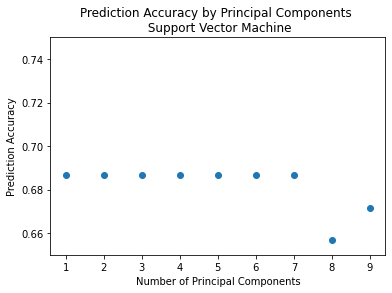

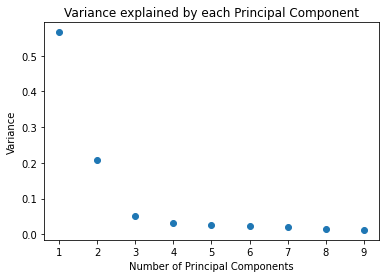

In [ ]:
df = pd.read_csv('master HTP SBC decode file_PropsbyBB.csv')
print(df.iloc[0:, 16:63])
X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63], df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()

score_lst = []
PCA_comps = []
for i in range(1,10):
  X_train_norm = sc.fit_transform(X_train)
  X_test_norm = sc.transform(X_test)



  pca = PCA(n_components = i)
  X_train_norm = pca.fit_transform(X_train_norm)
  X_test_norm = pca.transform(X_test_norm)


  clf1 = SVC(kernel='linear')
  clf1.fit(X_train_norm, y_train)
  y_pred_norm = clf1.predict(X_test_norm)

  explained_variance = pca.explained_variance_ratio_
  percentage = clf1.score(X_test_norm, y_test)


  PCA_comps.append(i)
  score_lst.append(accuracy_score(y_test, y_pred_norm))
  #print(cm)
  print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)) + "vs percentage " + str(percentage))


# plot accuracy as function of PC's
plt.scatter(PCA_comps, score_lst)
plt.title('Prediction Accuracy by Principal Components \n Support Vector Machine')
plt.xlabel('Number of Principal Components')
plt.ylim(ymin = 0.65, ymax = 0.75)
plt.ylabel('Prediction Accuracy')
plt.savefig('PredAccuracy_SVM.svg')
plt.show()


# plot variance explained by num PC's
plt.scatter(PCA_comps, explained_variance)
plt.title('Variance explained by each Principal Component')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.savefig('VariancebyPC_SVM.svg')
plt.show()

0.6865671641791045


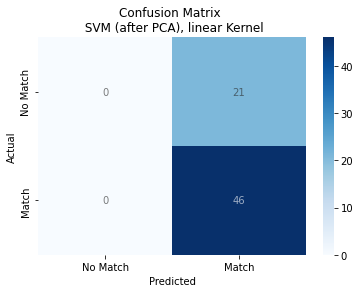

In [ ]:
#confusion matrix for optimal condition
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)
kerneltype = 'linear'


pca = PCA(n_components = 3 )
X_train_norm = pca.fit_transform(X_train_norm)
X_test_norm = pca.transform(X_test_norm)


clf1 = SVC(kernel=kerneltype)
clf1.fit(X_train_norm, y_train)
y_pred_norm = clf1.predict(X_test_norm)

explained_variance = pca.explained_variance_ratio_
percentage = clf1.score(X_test_norm, y_test)
print(percentage)
cm = confusion_matrix(y_test, y_pred_norm)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n SVM (after PCA), %s Kernel' % kerneltype);
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_SVMwPCA%s.svg" % kerneltype )



In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(16,16))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.savefig("Barplot features_SVMwPCA.svg")
    plt.show()
features_names = X_train_norm.columns
print(clf1.coef_)
f_importances(clf1.coef_[0], features_names)

AttributeError: ignored

#Polynomial SVM

In [ ]:

df = pd.read_csv('master HTP SBC decode file_PropsbyBB.csv')


X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63], df['Match?'], test_size= 0.2, random_state = 1 )
clf1 = SVC(kernel='linear')
# print(X_train)
# print(X_test)
clf1.fit(X_train, y_train)
predictions = clf1.predict(X_test)

# print(y_test)
# print(predictions)
percentage = clf1.score(X_test, y_test)
from sklearn.metrics import confusion_matrix
res = confusion_matrix(y_test, predictions)
print("Confusion Matrix")
print(res)
print(f"Test Set: {len(X_test)}")
print(f"Accuracy = {percentage*100} %")

Confusion Matrix
[[ 5 16]
 [ 3 43]]
Test Set: 67
Accuracy = 71.64179104477611 %


/content/drive/MyDrive/Colab Notebooks/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


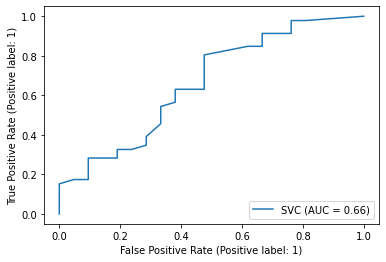

In [ ]:
import sklearn.metrics as metrics
metrics.plot_roc_curve(clf1, X_test, y_test)
plt.show()

# Random forest with PCA

In [ ]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 194 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=479b48fd4592573fd377a3e92597768ad747b8dcec3051b6856b9e30ae7223b3
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


In [ ]:
# Predictions with Normalization
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dtreeviz.trees import dtreeviz # will be used for tree visualization


In [ ]:

sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)



# pca = PCA(n_components = 3)
# X_train_norm = pca.fit_transform(X_train_norm)
# X_test_norm = pca.transform(X_test_norm)

# explained_variance = pca.explained_variance_ratio_
# print(explained_variance)
# print(pca.components_)

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectPercentile as feature_selector
from sklearn import preprocessing

X_train_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(preprocessing.scale(X_test),columns =X_test.columns)

pca = PCA(n_components = 8)
X_train_norm = pca.fit_transform(X_train_scaled)
X_test_norm = pca.transform(X_test_scaled)

classifier = RandomForestClassifier(max_depth = 2, random_state=1)
classifier.fit(X_train_norm, y_train)

# Predicting the Test set results
y_pred_norm = classifier.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred_norm)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)))


err = mean_squared_error(y_pred_norm, y_test)
print(err)




ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n Random Forest');
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_RFwPCA_PC8.svg")


In [ ]:
components = pd.DataFrame(pca.components_,columns=X_train_scaled.columns)
components.to_csv('components.csv')

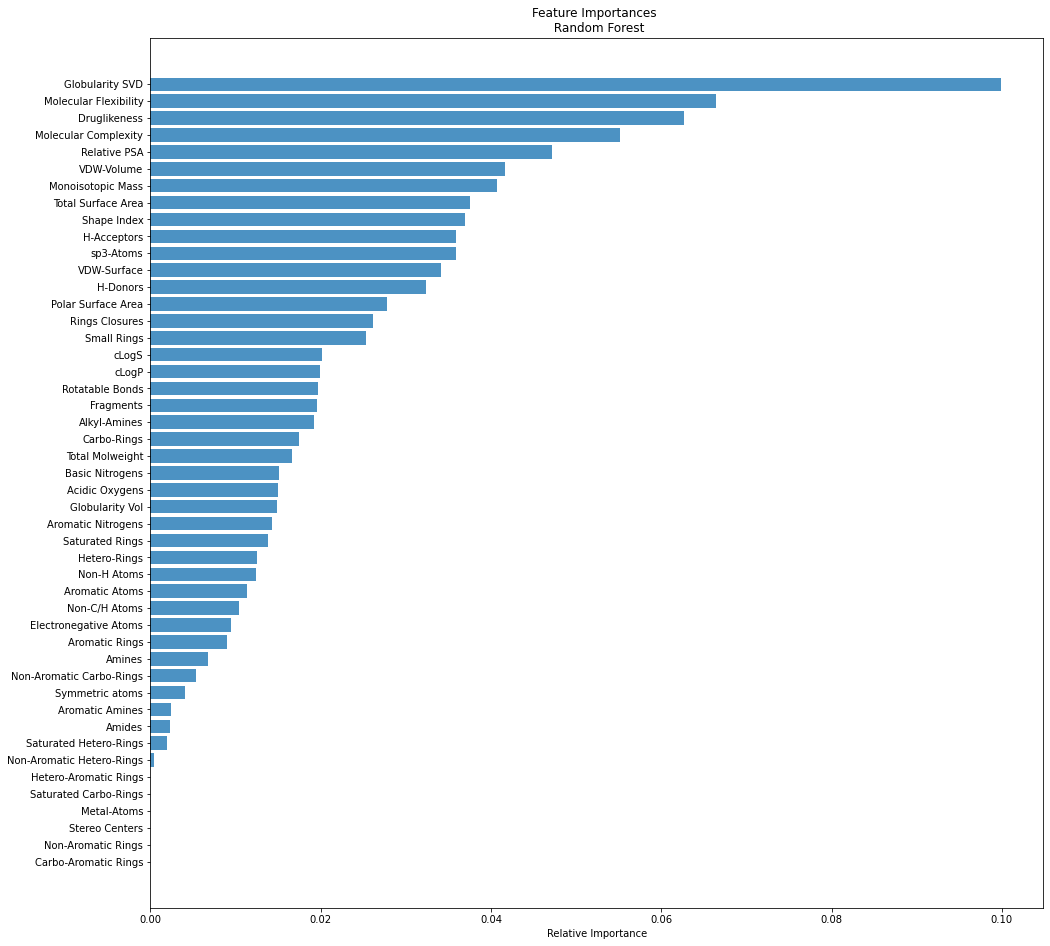

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

features = trans_cols
importances = classifier.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,16))
plt.title('Feature Importances \n Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center', alpha = 0.8)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("FeatureImportantces_Barh_RFwPCA.svg")
plt.show()

In [ ]:
print(X_train_norm)

[[ 1.24950334  1.2774213   1.30946143 ... -1.21021906  1.3365308
   1.32461875]
 [ 0.70550554  0.4377208   0.46101757 ... -0.75196872  0.57717324
   0.5390107 ]
 [ 1.31614072  1.34095546  1.48636726 ... -1.14233012  1.29109993
   1.30414661]
 ...
 [ 0.81668937  0.5497951   0.67602038 ... -0.79911381  0.70767202
   0.69259251]
 [-0.59983236 -0.58669571 -0.63197629 ...  0.1749039  -0.62573299
  -0.69437435]
 [ 1.05094664  1.07734896  0.47616835 ... -1.02635318  1.11139972
   1.12430175]]


In [ ]:
from IPython.display import Image, display_svg, SVG
viz = dtreeviz(classifier.estimators_[0],
               np.array(X_train_norm),
               y_train,
               feature_names=trans_cols,
               target_name="Observed Mass",
               class_names = ['Not Matching', 'Matching'],
               orientation = "LR",
               scale = 1,
               colors = {'classes':[None, None,['#1f77b4', 'LightGrey']], "rect_edge":'White', 'pie':'White'})
               #X=np.array(X_test_norm)[4] )
viz.save('Dtreeviz.svg')
viz

NameError: ignored

     Total Molweight  Monoisotopic Mass     cLogP     cLogS  H-Acceptors  \
0           1.249503           1.277421  1.309461 -1.299439     0.819307   
1           0.705506           0.437721  0.461018 -0.633169     0.075242   
2           1.316141           1.340955  1.486367 -1.414514     0.819307   
3          -0.710675          -0.698479 -0.232084  0.548027    -0.668822   
4          -0.710675          -0.698479 -0.232084  0.548027    -0.668822   
..               ...                ...       ...       ...          ...   
262        -0.814020          -0.802595 -1.077510  1.058028     0.075242   
263         1.407929           1.437267  0.770760 -0.713318     2.307436   
264         0.816689           0.549795  0.676020 -0.754065     0.075242   
265        -0.599832          -0.586696 -0.631976  0.809520     0.075242   
266         1.050947           1.077349  0.476168 -0.728990     1.563372   

     H-Donors  Total Surface Area  Relative PSA  Polar Surface Area  \
0    0.292174   

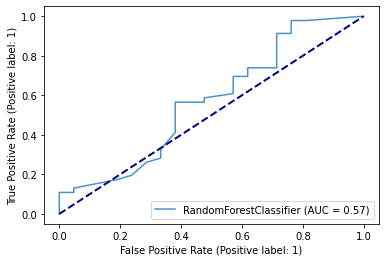

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


y = np.array(df['Match?'])

# Binarize the output
lb = LabelBinarizer()
label = lb.fit_transform(y)
label = np.hstack((label, 1 - label))
n_classes = label.shape[1]
# print(y)
# print(label)
# print(n_classes)

df2 = pd.DataFrame(X_train_norm, columns = X_train.columns)
print(df2)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63],df['Match?'] , test_size= 0.2, random_state = 1 )

sc = StandardScaler()
X_train_norm = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test_norm = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

classifier = RandomForestClassifier(max_depth = 2, random_state=1)
classifier.fit(X_train, y_train)

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.show()

     Total Molweight  Monoisotopic Mass   cLogP  cLogS  H-Acceptors  H-Donors  \
0            112.175         112.100048 -0.3176 -0.506            2         2   
1            401.461         401.162709  3.8900 -5.982            5         2   
2            166.175         166.062995  1.4186 -1.991            3         1   
3            114.191         114.115698  0.0864 -0.856            2         2   
4            401.461         401.162709  3.8900 -5.982            5         2   
..               ...                ...     ...    ...          ...       ...   
329          373.407         373.131409  3.0434 -5.219            5         2   
330          180.159         180.042260  0.7825 -1.407            4         3   
331          358.868         322.168128  2.8631 -4.899            4         2   
332          422.867         422.103335  3.2486 -5.342            6         2   
333          180.159         180.042260  0.7825 -1.407            4         3   

     Total Surface Area  Re

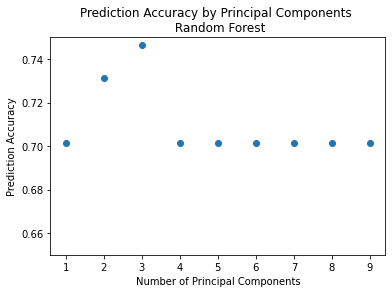

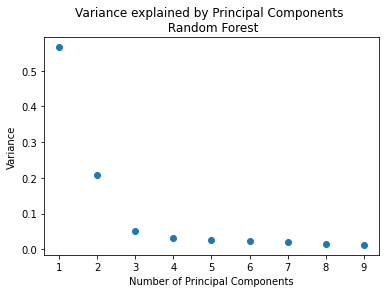

In [ ]:
#for loop to find  best conditions for PCA in random forest
df = pd.read_csv('master HTP SBC decode file_PropsbyBB.csv')
print(df.iloc[0:, 16:63])
X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63], df['Match?'], test_size= 0.2, random_state = 1 )
score_lst = []
PCA_comps = []
for i in range(1,10):
  X_train_norm = sc.fit_transform(X_train)
  X_test_norm = sc.transform(X_test)



  pca = PCA(n_components = i)
  X_train_norm = pca.fit_transform(X_train_norm)
  X_test_norm = pca.transform(X_test_norm)



  classifier = RandomForestClassifier(max_depth=3, random_state=1)
  classifier.fit(X_train_norm, y_train)

  # Predicting the Test set results
  y_pred_norm = classifier.predict(X_test_norm)
  cm = confusion_matrix(y_test, y_pred_norm)
  explained_variance = pca.explained_variance_ratio_

  PCA_comps.append(i)
  score_lst.append(accuracy_score(y_test, y_pred_norm))
  print(cm)
  print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)))


# plot accuracy as function of PC's
plt.scatter(PCA_comps, score_lst)
plt.title('Prediction Accuracy by Principal Components \n Random Forest')
plt.xlabel('Number of Principal Components')
plt.ylabel('Prediction Accuracy')
plt.ylim(ymin = 0.65, ymax = 0.75)
plt.savefig('PredAccuracy_RFwPCA.svg')
plt.show()


# plot variance explained by num PC's
plt.scatter(PCA_comps, explained_variance)
plt.title('Variance explained by Principal Components \n Random Forest')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.savefig('VariancebyPC_RFwPCA.svg')
plt.show()

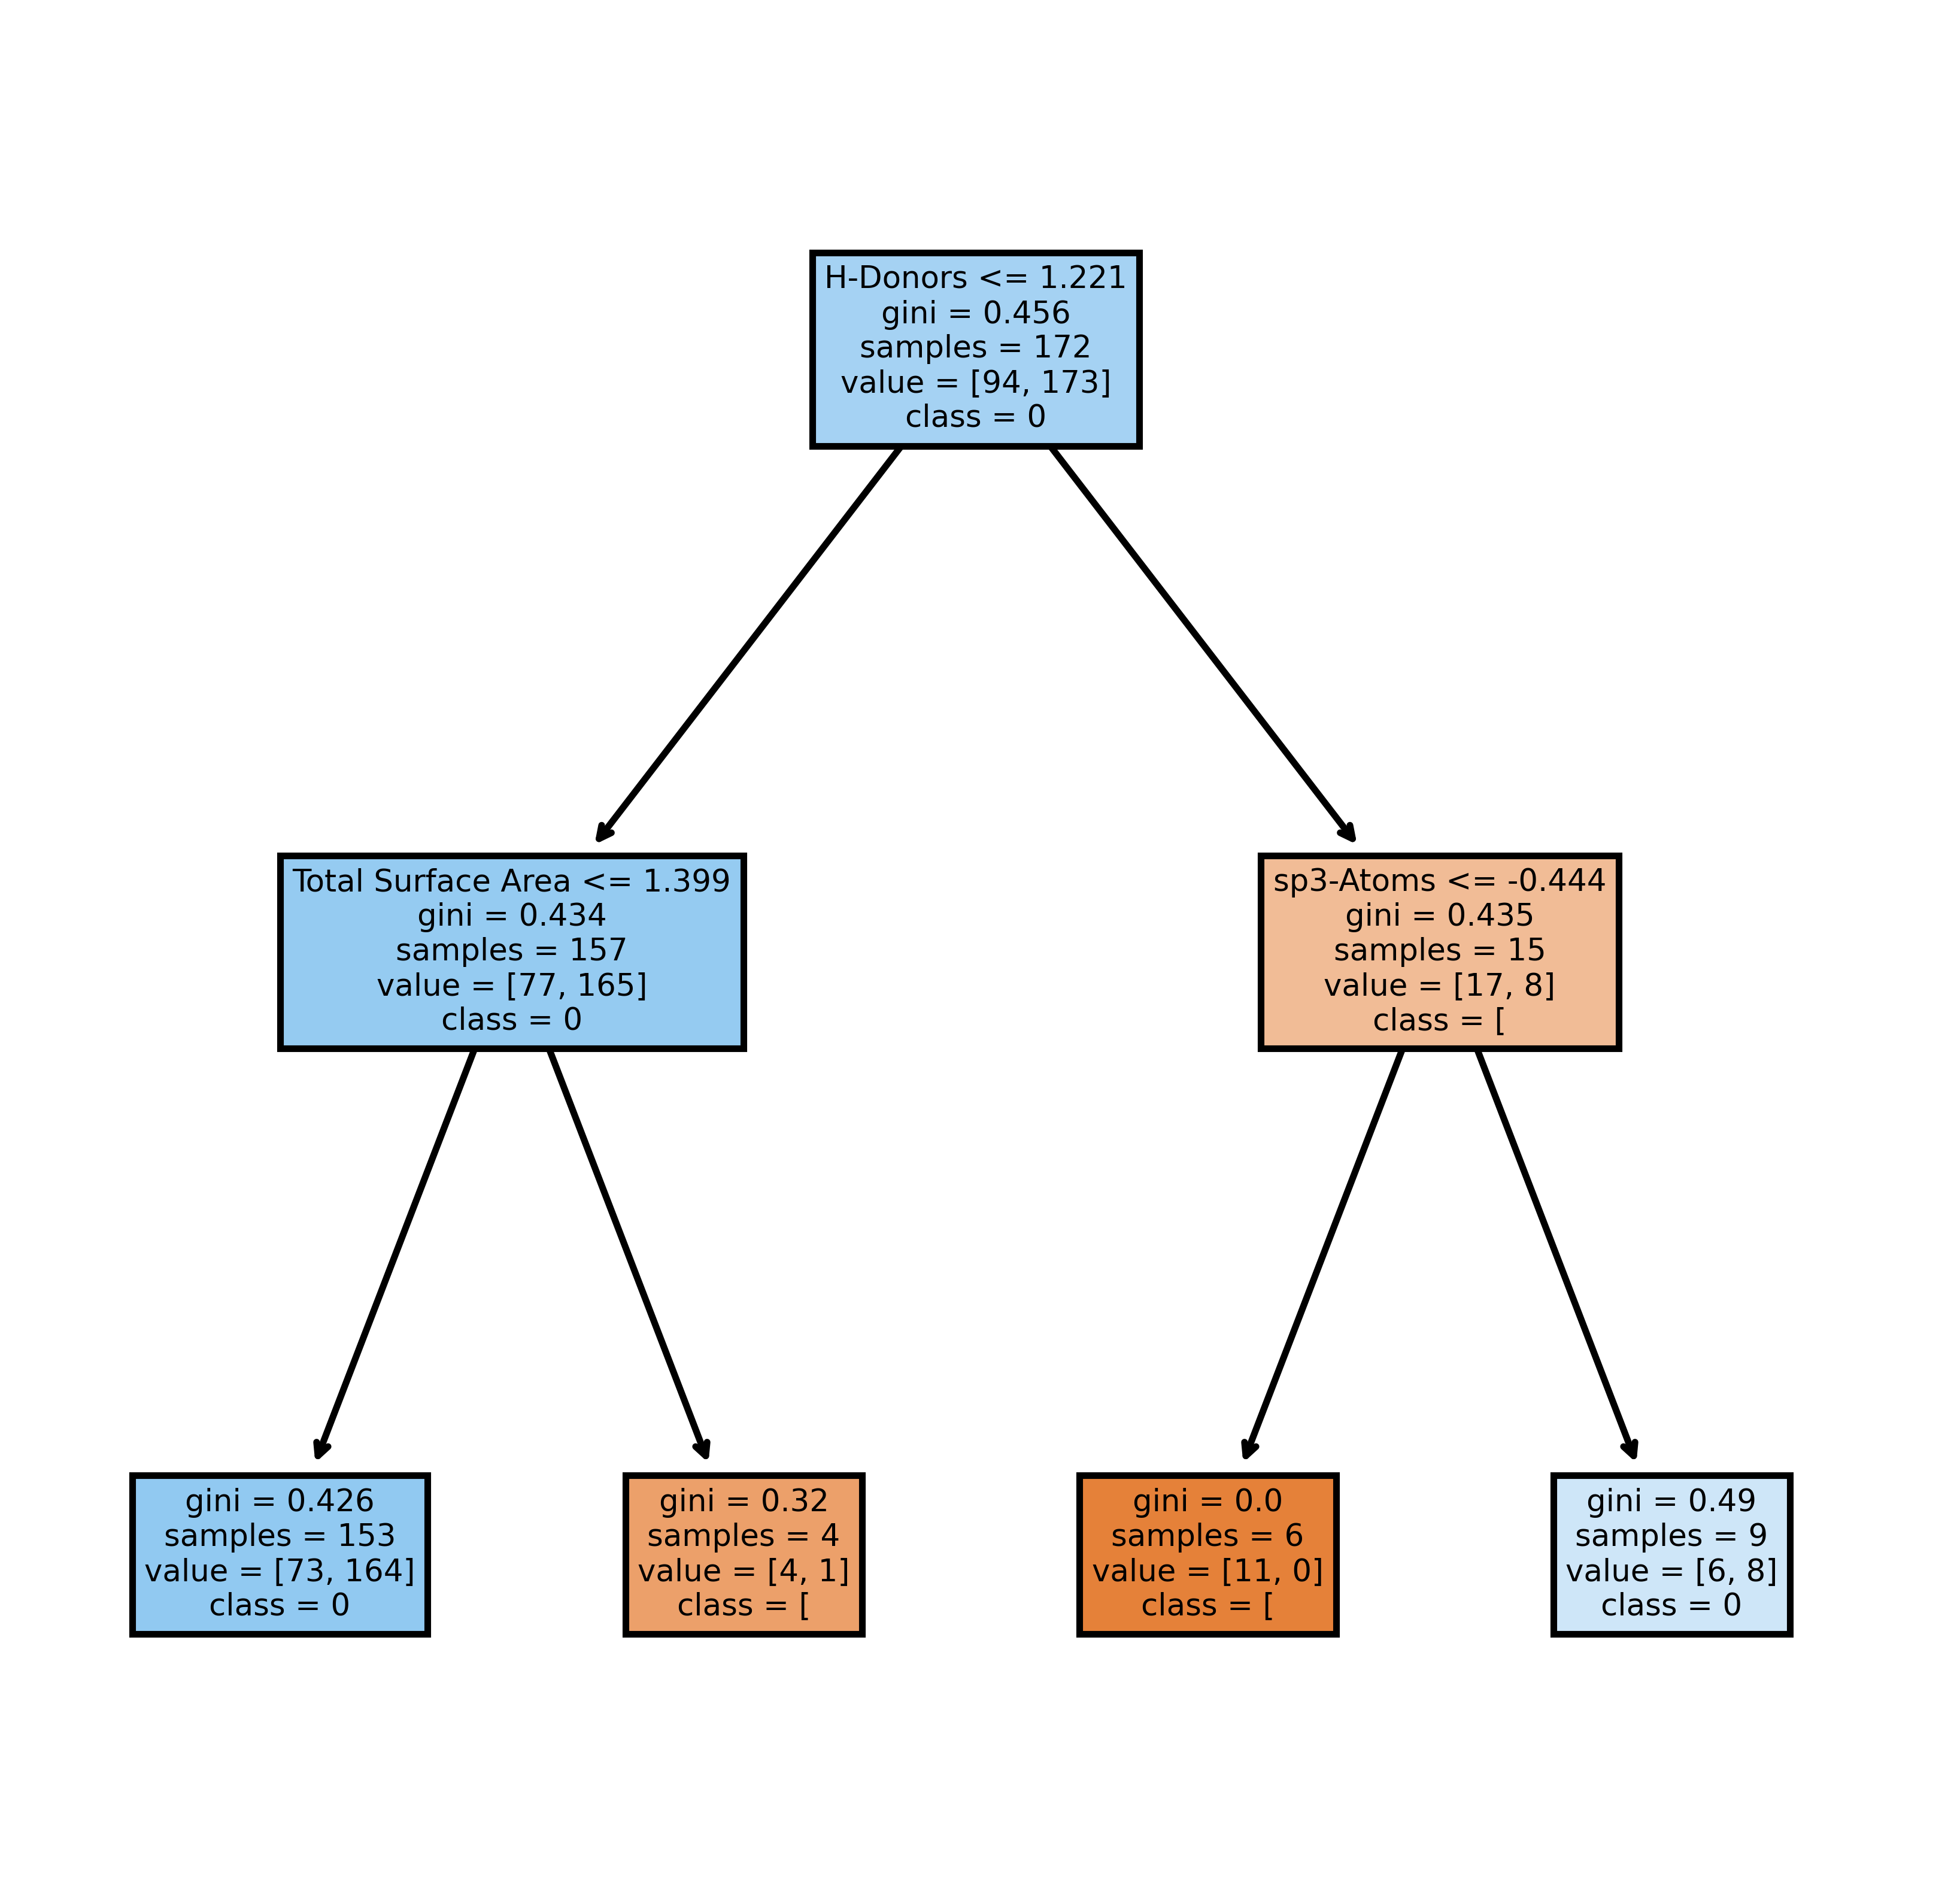

In [ ]:
#plotting the decision tree
fn=trans_cols
cn=str(y_pred_norm)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
tree.plot_tree(classifier.estimators_[0],
               feature_names = fn,
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree_wPCA.svg')

NameError: ignored

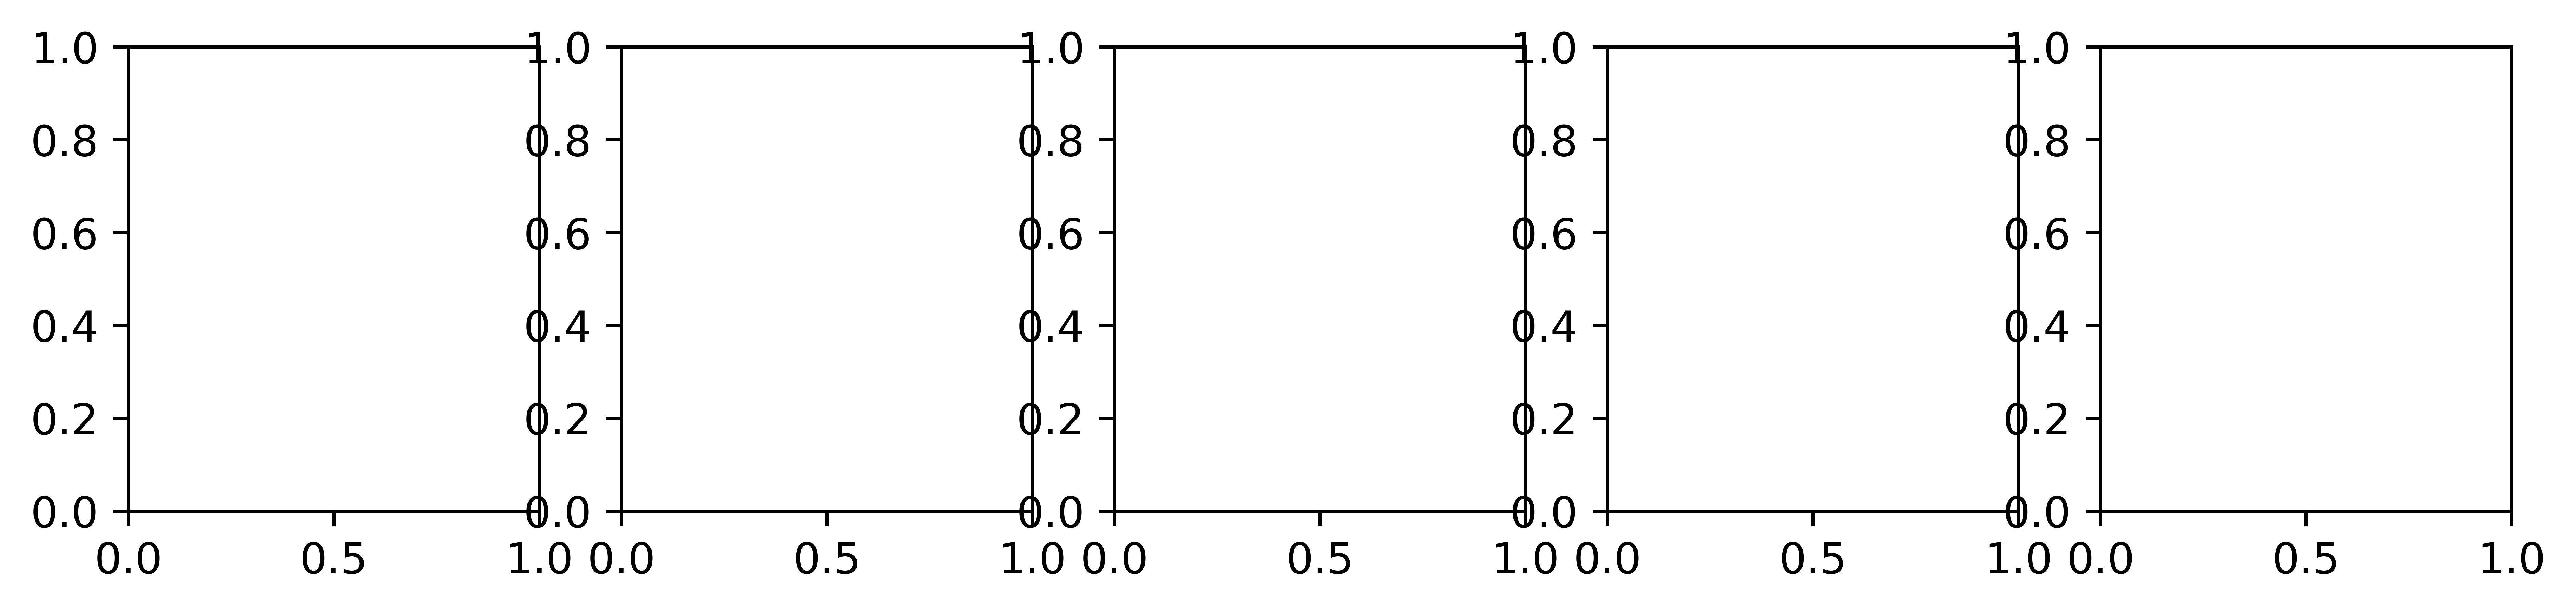

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(classifier.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_wPCA_5trees.svg')

#Random forest without PCA


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing

In [ ]:
# with no PCA
df = pd.read_csv('master HTP SBC decode file_PropsbyBB_20220527.csv')
#print(df.iloc[0:, 16:63])

X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:, 16:63], df['Match?'], test_size= 0.2, random_state = 1 )
sc = StandardScaler()
# X_train_RF = X_train
# X_test_RF = X_test
X_train_RF = sc.fit_transform(X_train)
X_test_RF= sc.transform(X_test)


classifier = RandomForestClassifier(max_depth=2, random_state=1)
classifier.fit(X_train_RF, y_train)

# Predicting the Test set results
y_pred_norm = classifier.predict(X_test_RF)
cm = confusion_matrix(y_test, y_pred_norm)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)))

[[ 12  50]
 [  5 100]]
Accuracy: 0.6706586826347305


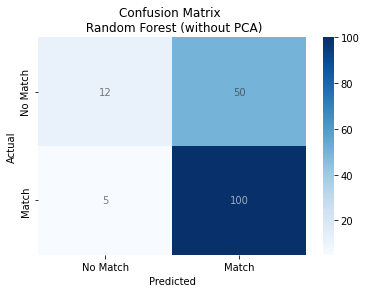

In [ ]:


cm = confusion_matrix(y_test, y_pred_norm)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n Random Forest (without PCA)');
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_RFnoPCA.svg")


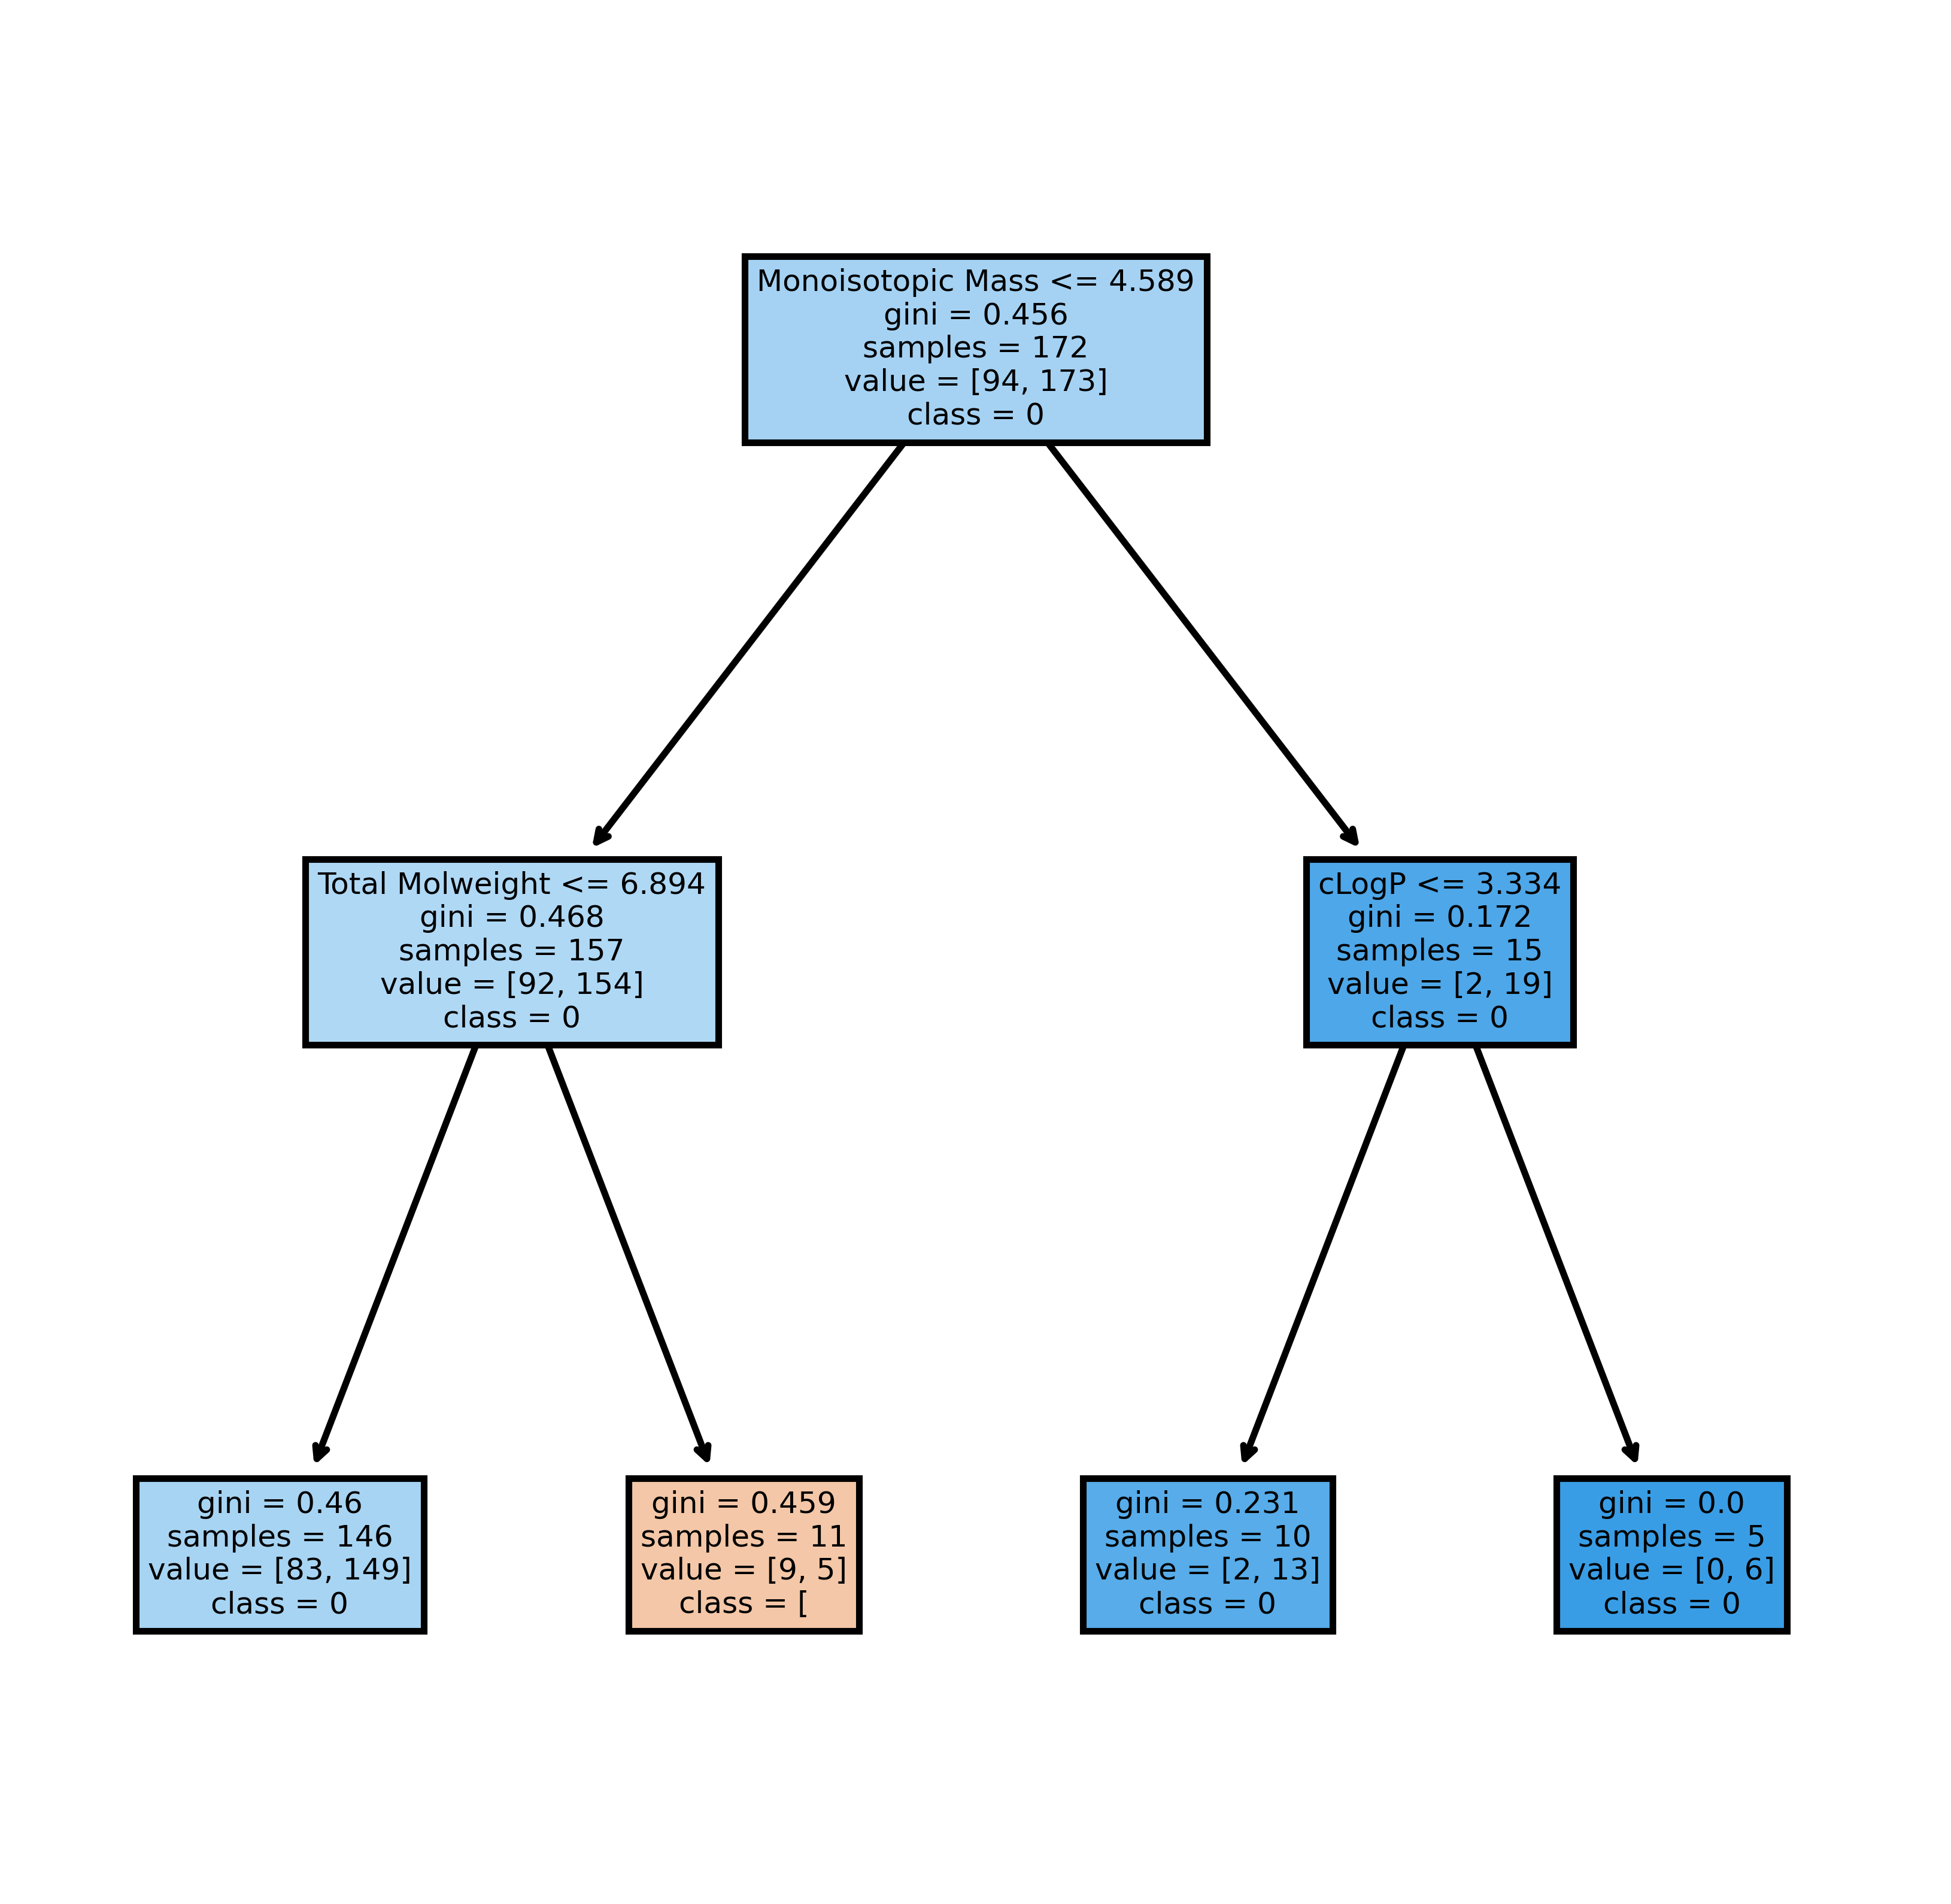

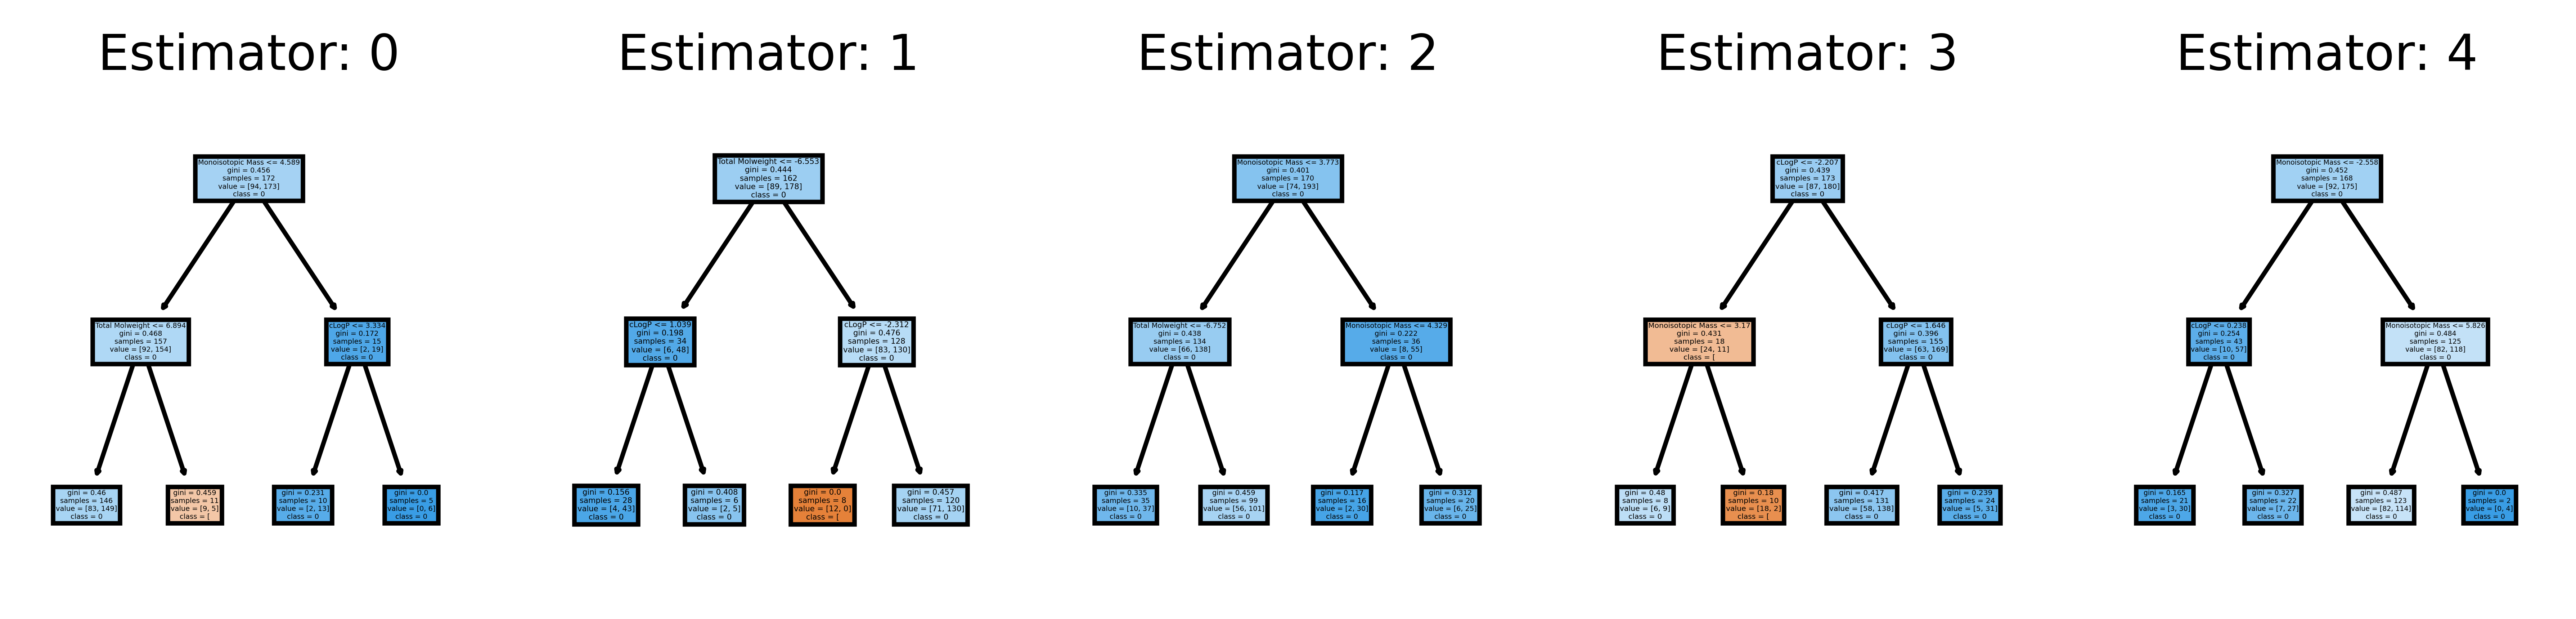

In [ ]:
#plotting the decision tree
fn=X_train.columns
cn=str(y_pred)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
tree.plot_tree(classifier.estimators_[0],
               feature_names = fn,
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree_noPCA.svg')

fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0,5):
    tree.plot_tree(classifier.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_noPCA_5trees.svg')

#Fingerprints with RDkit

## install RDkit and visualization functionality

In [ ]:
%%time
!pip install -q condacolab

CPU times: user 24.4 ms, sys: 8.08 ms, total: 32.5 ms
Wall time: 1.53 s


In [ ]:
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.2 MB/s 
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 3.1 MB 47.6 MB/s 


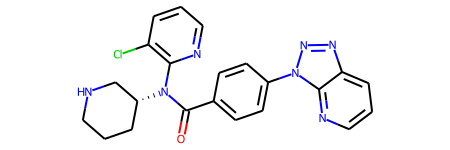

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

IPythonConsole.ipython_useSVG=True

mol = Chem.MolFromSmiles("O=C(C1=CC=C(N2C(N=CC=C3)=C3N=N2)C=C1)N([C@H]4CNCCC4)C5=C(Cl)C=CC=N5")
mol

##Morgan fingeprint preparation

In [ ]:
def generate_morgan_matrix(smiles, radius = 3, bits = 2048):
  # Function to generate morgan matrix, may take a couple mins depending on how many molecules are being read in.
  #input should be a pandas Series of SMILES of molecules of interest

  morgan_matrix = np.zeros((1,2048)) # we want 2048 bits
  l = len(smiles) # number of elements in the series

  for i in range(l):
    # For each compound, get the structure, convert to Morgan Fingerprint
    # and add to data matrix
    try:
      compound = Chem.MolFromSmiles(smiles[i])
      fp = Chem.AllChem.GetMorganFingerprintAsBitVect(compound, radius, nBits = bits)
      fp = fp.ToBitString()
      matrix_row = np.array([int(x) for x in list(fp)])
      morgan_matrix = np.row_stack((morgan_matrix, matrix_row))

      #checker
      if i%50 == 0:
        percentage = np.round(100*(i/l), 1)
        print(f'{percentage}% done')
    except:
      print(f'Problem index: {i}')

  #delete first row of zeros:
  morgan_matrix = np.delete(morgan_matrix, 0, axis = 0)
  print('\n')
  print(f'Morgan Matrix dimensions:{morgan_matrix.shape}')
  return morgan_matrix



In [ ]:
##generate fingerprints with radius 2 ##

IPythonConsole.ipython_useSVG=True

os.chdir('/content/drive/MyDrive/Colab Notebooks')
# Generate list of smiles to make fingerprints with. Get data from dataset using SMILES.


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master HTP SBC decode file_PropsbyBB_20220527.csv')
df.head()
fp_df = df[["Bead No", "BBSMILES", "Name", "SMILES", "Match?"]]
#print(fp_df)

Morgan_matrix_data = generate_morgan_matrix(fp_df['SMILES'])
#print(Morgan_matrix_data[0, 0:])
matrix_df = pd.DataFrame(Morgan_matrix_data)
#print(matrix_df)

## merge fp data with the original DF
fp_df = pd.concat([fp_df, matrix_df], axis=1, join='inner')
#display(fp_df)
fp_df.to_csv('test.csv')

print(fp_df.iloc[0:, 5:])

np.save('20220527_morganMatrix_rad2.npy', fp_df)
## split data into traiing and test.


In [ ]:
def split_BB_types(master_file = "", BBtypes = []):

  df = pd.read_csv(master_file)

  #subset dataframe with only necessary information
  fp_df = df[["Bead No", "Name", "SMILES", "Match?"]]



  #Initialize Dataframes for each BB
  BB1_outcomes = pd.DataFrame(columns = ["Bead No","Name", "SMILES", "Match?"])
  BB2_outcomes = pd.DataFrame(columns = ["Bead No", "Name", "SMILES", "Match?"])
  BB3_outcomes = pd.DataFrame(columns = ["Bead No","Name", "SMILES", "Match?"])


  # create Dataframes with each type of BB:
  for c, i in enumerate(fp_df['Name']):

    if(i[0:2]) == BBtypes[0]:
      BB1_outcomes.loc[len(BB1_outcomes)] = fp_df.iloc[c]
      #print(Diamine_outcomes)
    elif(i[0:2]) == BBtypes[1]:
      BB2_outcomes.loc[len(BB2_outcomes)] = fp_df.iloc[c]
      #print(AA_outcomes)
    elif(i[0:2]) == BBtypes[2]:
      BB3_outcomes.loc[len(BB3_outcomes)] = fp_df.iloc[c]
    else:
      continue

  BB1_outcomes.to_csv('%s_Outcomes.csv' % BBtypes[0])
  BB2_outcomes.to_csv('%s_Outcomes.csv' % BBtypes[1])
  BB3_outcomes.to_csv('%s_Outcomes.csv' % BBtypes[2])

In [ ]:
split_BB_types(master_file = 'master HTP SBC decode file_PropsbyBB_20220527.csv',
               BBtypes = ["DA", "AA", "CA"])


In [ ]:
## Make Fingerprints for each BB with radius 3 ##
os.chdir('/content/drive/MyDrive/Colab Notebooks')

BB1_outcomes = pd.read_csv('DA_Outcomes.csv')
BB2_outcomes = pd.read_csv('AA_Outcomes.csv')
BB3_outcomes = pd.read_csv('CA_Outcomes.csv')



## merge fp data with the original DF

#BB1
Morgan_matrix_data_DA = generate_morgan_matrix(BB1_outcomes['SMILES'], radius = 3, bits = 2048)
matrix_df_DA = pd.DataFrame(Morgan_matrix_data_DA)

fp_df = pd.concat([BB1_outcomes, matrix_df_DA], axis=1, join='inner')
fp_df.to_csv('DA_outcomes_rad3_FP.csv')
np.save('20220527_morganMatrix_DA_rad3.npy', fp_df)

#BB2
Morgan_matrix_data_AA = generate_morgan_matrix(BB2_outcomes['SMILES'], radius = 3, bits = 2048)
matrix_df_AA = pd.DataFrame(Morgan_matrix_data_AA)

fp_df = pd.concat([BB2_outcomes, matrix_df_AA], axis=1, join='inner')
fp_df.to_csv('AA_outcomes_rad3_FP.csv')
np.save('20220527_morganMatrix_AA_rad3.npy', fp_df)

#BB3
Morgan_matrix_data_CA = generate_morgan_matrix(BB3_outcomes['SMILES'], radius = 3, bits = 2048)
matrix_df_CA = pd.DataFrame(Morgan_matrix_data_CA)

fp_df = pd.concat([BB3_outcomes, matrix_df_CA], axis=1, join='inner')
fp_df.to_csv('CA_outcomes_rad3_FP.csv')
np.save('20220527_morganMatrix_CA_rad3.npy', fp_df)


print(fp_df.iloc[0:, 5:])



0.0% done
17.9% done
35.7% done
53.6% done
71.4% done
89.3% done


Morgan Matrix dimensions:(280, 2048)
0.0% done
18.3% done
36.6% done
54.9% done
73.3% done
91.6% done


Morgan Matrix dimensions:(273, 2048)
0.0% done
19.9% done
39.8% done
59.8% done
79.7% done
99.6% done


Morgan Matrix dimensions:(251, 2048)
     0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
246   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
247   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 

In [ ]:

def run_SVC_noPCA (fileName = "", scaling = "", kernel = "", **kwargs):
  fp_df = pd.read_csv(fileName)
  #print(fp_df.iloc[0:, 6:])
  X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 6:], fp_df['Match?'], test_size= 0.2, random_state = 1 )

  sc = StandardScaler()

  score_lst = []
  PCA_comps = []
  if scaling == "norm":
    X_train_norm = sc.fit_transform(X_train)
    X_test_norm = sc.transform(X_test)

    clf1 = SVC(kernel=kernel, **kwargs)
    clf1.fit(X_train_norm, y_train)
    y_pred_norm = clf1.predict(X_test_norm)

    percentage = clf1.score(X_test_norm, y_test)


    cm = confusion_matrix(y_test, y_pred_norm)

    print(cm)
    print(fileName)
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)) + "vs percentage " + str(percentage))
  else:

    clf1 = SVC(kernel=kernel, **kwargs)
    clf1.fit(X_train, y_train)
    y_pred = clf1.predict(X_test)

    percentage = clf1.score(X_test, y_test)


    cm = confusion_matrix(y_test, y_pred)

    print(cm)
    print(fileName)
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred)) + "vs percentage " + str(percentage))


In [ ]:
kerneltype = "linear"

run_SVC_noPCA('CA_outcomes_rad3_FP.csv', scaling = "", kernel = kerneltype)
run_SVC_noPCA('DA_outcomes_rad3_FP.csv', scaling = "",kernel = kerneltype)
run_SVC_noPCA('AA_outcomes_rad3_FP.csv', scaling = "",kernel = kerneltype)

[[ 9 14]
 [ 4 24]]
CA_outcomes_rad3_FP.csv
Accuracy: 0.6470588235294118vs percentage 0.6470588235294118
[[ 0 22]
 [ 0 34]]
DA_outcomes_rad3_FP.csv
Accuracy: 0.6071428571428571vs percentage 0.6071428571428571
[[11 22]
 [ 7 15]]
AA_outcomes_rad3_FP.csv
Accuracy: 0.4727272727272727vs percentage 0.4727272727272727


#(Fingerprints)

## SVM with PCA

In [ ]:

fp_df =

X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()
kerneltype = 'sigmoid'
score_lst = []
PCA_comps = []
for i in range(1,30):
  X_train_norm = sc.fit_transform(X_train)
  X_test_norm = sc.transform(X_test)



  pca = PCA(n_components = i)
  X_train_norm = pca.fit_transform(X_train_norm)
  X_test_norm = pca.transform(X_test_norm)


  clf1 = SVC(kernel=kerneltype)
  clf1.fit(X_train_norm, y_train)
  y_pred_norm = clf1.predict(X_test_norm)

  explained_variance = pca.explained_variance_ratio_
  percentage = clf1.score(X_test_norm, y_test)


  PCA_comps.append(i)
  score_lst.append(accuracy_score(y_test, y_pred_norm))
  #print(cm)
  print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)) + "vs percentage " + str(percentage))


# plot accuracy as function of PC's
plt.scatter(PCA_comps, score_lst)
plt.title('Prediction Accuracy by Principal Components \n Support Vector Machine %s' % kerneltype)
plt.xlabel('Number of Principal Components')
plt.ylabel('Prediction Accuracy')
plt.savefig('PredAccuracy_SVM_FP_%s.svg' % kerneltype)
plt.show()


# plot variance explained by num PC's
plt.scatter(PCA_comps, explained_variance)
plt.title('Variance explained by each Principal Component %s' % kerneltype)
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.savefig('VariancebyPC_SVM_FP%s.svg' % kerneltype)
plt.show()

In [ ]:
#SVM w PCA

X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()
kerneltype = 'linear'
score_lst = []
PCA_comps = []

X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)



pca = PCA(n_components = i)
X_train_norm = pca.fit_transform(X_train_norm)
X_test_norm = pca.transform(X_test_norm)


clf1 = SVC(kernel=kerneltype)
clf1.fit(X_train_norm, y_train)
y_pred_norm = clf1.predict(X_test_norm)

explained_variance = pca.explained_variance_ratio_
percentage = clf1.score(X_test_norm, y_test)


cm = confusion_matrix(y_test, y_pred_norm)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n SVM (without PCA), %s Kernal' % kerneltype);
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_SVMPCA_%s.svg" % kerneltype)
#print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)) + "vs percentage " + str(percentage))


In [ ]:
#SVM no PCA

Accuracy = 0.5688622754491018


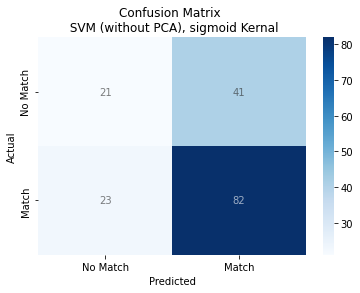

In [ ]:
from sklearn.metrics import confusion_matrix
print()
X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )
kerneltype = 'sigmoid'
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)
clf1 = SVC(kernel=kerneltype)
# # print(X_train)
# # print(X_test)
clf1.fit(X_train_norm, y_train)
predictions = clf1.predict(X_test_norm)
# # print(y_test)
# # print(predictions)
percentage = clf1.score(X_test_norm, y_test)
print('Accuracy = ' + str(accuracy_score(y_test, y_pred_norm)))

cm = confusion_matrix(y_test, predictions)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n SVM (without PCA), %s Kernal' % kerneltype);
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_SVMnoPCA%s_FP.svg" % kerneltype)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()
kerneltype = 'linear'
score_lst = []
PCA_comps = []
for i in range(1,30):
  X_train_norm = sc.fit_transform(X_train)
  X_test_norm = sc.transform(X_test)

  clf1 = SVC(kernel=kerneltype)
  clf1.fit(X_train_norm, y_train)
  y_pred_norm = clf1.predict(X_test_norm)
  percentage = clf1.score(X_test_norm, y_test)


  PCA_comps.append(i)
  score_lst.append(accuracy_score(y_test, y_pred_norm))
  #print(cm)
  print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)) + "vs percentage " + str(percentage))


# plot accuracy as function of PC's


##RF NO PCA

In [ ]:
# Predictions with Normalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dtreeviz.trees import dtreeviz

[[  8  54]
 [  3 102]]
Accuracy: 0.6586826347305389


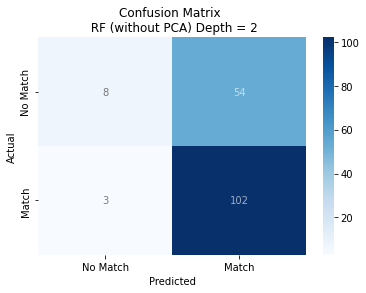

In [ ]:
# no PCA
X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()

X_train_RF = sc.fit_transform(X_train)
X_test_RF = sc.fit_transform(X_test)


classifier = RandomForestClassifier(max_depth=4, random_state=1)
classifier.fit(X_train_RF, y_train)

# Predicting the Test set results
y_pred_norm = classifier.predict(X_test_RF)
cm = confusion_matrix(y_test, y_pred_norm)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)))

cm = confusion_matrix(y_test, y_pred_norm)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n RF (without PCA) Depth = 2');
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_RFnoPCA%s_FP.svg")

##RF with PCA

[[14 48]
 [ 9 96]]
Accuracy: 0.6586826347305389


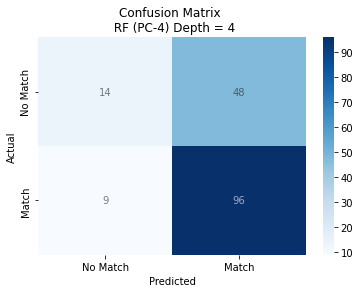

In [ ]:
# no PCA
X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )

sc = StandardScaler()
pca = PCA(n_components = 4)

X_train_scale = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)
X_test_scale = pd.DataFrame(preprocessing.scale(X_test),columns =X_test.columns)

X_train_RF = pca.fit_transform(X_train_scale)
X_test_RF = pca.fit_transform(X_test_scale)

classifier = RandomForestClassifier(max_depth=4, random_state=1)
classifier.fit(X_train_RF, y_train)

# Predicting the Test set results
y_pred_norm = classifier.predict(X_test_RF)
cm = confusion_matrix(y_test, y_pred_norm)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)))
cm = confusion_matrix(y_test, y_pred_norm)

ax= plt.subplot()
plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues", annot_kws={'alpha':0.6});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix \n RF (PC-4) Depth = 4');
ax.xaxis.set_ticklabels(['No Match', 'Match']); ax.yaxis.set_ticklabels(['No Match', 'Match']);

plt.savefig("confusionmatrix_RF_PCA_FP.svg")

In [ ]:

components = pd.DataFrame(pca.components_,columns=X_train_scale.columns)
components.to_csv('components_fp.csv')

# looking at match frequency

In [ ]:
## BB by BB ##

BB1_outcomes = pd.read_csv('DA_Outcomes.csv')
BB2_outcomes = pd.read_csv('AA_Outcomes.csv')
BB3_outcomes = pd.read_csv('CA_Outcomes.csv')


fp_df_BBMatchCounts = pd.DataFrame(BB3_outcomes.groupby(['Name',"SMILES", 'Match?'])['Match?'].size().reset_index(name = 'Match Count'))
print(fp_df_BBMatchCounts)
fp_df_BBMatchCounts.to_csv('test.csv')
new_df = pd.DataFrame(fp_df_BBMatchCounts.groupby(['Name', 'SMILES']).sum().reset_index())
new_df.columns = ['Name', 'SMILES', 'MatchTypes','TotalCounts']
print(new_df)

df = fp_df_BBMatchCounts
nMatches = []
for index,entry in df.iterrows():
  #print(str(entry['Match?']))
  if entry['Match?'] == 1:
    nMatches.append(entry['Match Count'])
  elif entry['Match?'] == 0 and df.iloc[index-1]['Match?'] == 0:
    nMatches.append(0)
  else:
    continue
print(nMatches)
column_values = pd.Series(nMatches)
new_df.insert(loc = 4,column='MassMatches', value=column_values)
freq = new_df['MassMatches']/new_df['TotalCounts']
print(freq)

new_df.insert(loc = 5,column='MatchFreq', value=freq)

print(new_df)
new_df.to_csv('test2.csv')


      Name                         SMILES  Match?  Match Count
0   CA-129               Cc1nc(C(O)=O)cs1       0            2
1   CA-129               Cc1nc(C(O)=O)cs1       1            6
2   CA-134                     OC(CCCS)=O       0            9
3   CA-134                     OC(CCCS)=O       1            1
4   CA-171    OC(c1cc(-c2ccccc2)n[nH]1)=O       0            7
5   CA-171    OC(c1cc(-c2ccccc2)n[nH]1)=O       1           17
6   CA-185       OC(c(cc1)cc2c1[nH]nc2)=O       0            1
7   CA-185       OC(c(cc1)cc2c1[nH]nc2)=O       1            8
8   CA-189      OC(/C=C/c(cc1)cc(O)c1O)=O       0           27
9   CA-189      OC(/C=C/c(cc1)cc(O)c1O)=O       1           10
10    CA-2     OC(c(cc1)cc(CCC2)c1C2=O)=O       0            9
11    CA-2     OC(c(cc1)cc(CCC2)c1C2=O)=O       1           12
12  CA-206          OC(c(cc1)cc2c1ocn2)=O       0            8
13  CA-206          OC(c(cc1)cc2c1ocn2)=O       1            5
14  CA-221              OC(c(cc1)ncc1O)=O       0      

In [ ]:

df = pd.read_csv('test2.csv')
df.head()
fp_df = df[["Name", "SMILES", "TotalCounts", "MassMatches", "MatchFreq"]]
#print(fp_df)

Morgan_matrix_data = generate_morgan_matrix(fp_df['SMILES'])
#print(Morgan_matrix_data[0, 0:])
matrix_df = pd.DataFrame(Morgan_matrix_data)
#print(matrix_df)

## merge fp data with the original DF
fp_df = pd.concat([fp_df, matrix_df], axis=1, join='inner')
#display(fp_df)
fp_df.to_csv('test.csv')

#print(fp_df.iloc[0:, 5:])
fp_df.to_csv('20220527_MatchRates_wFP_CAonly.csv')

np.save('20220527_morganMatrix_matchRates_CAonly.npy', fp_df)
## split data into traiing and test.

0.0% done


Morgan Matrix dimensions:(21, 2048)


In [ ]:
#Studying data
#how many times did each BB appear in the df
fp_df.read_csv('20220527_MatchRates_wFP.csv')
fp_df_BBMatchCounts = pd.DataFrame(fp_df.groupby(['Name',"SMILES", 'Match?'])['Match?'].size().reset_index(name = 'Match Count'))
print(fp_df_BBMatchCounts)
fp_df_BBMatchCounts.to_csv('test.csv')
new_df = pd.DataFrame(fp_df_BBMatchCounts.groupby(['Name', 'SMILES']).sum().reset_index())
new_df.columns = ['Name', 'SMILES', 'MatchTypes','TotalCounts']
print(new_df)

df = fp_df_BBMatchCounts
nMatches = []
for index,entry in df.iterrows():
  #print(str(entry['Match?']))
  if entry['Match?'] == 1:
    nMatches.append(entry['Match Count'])
  elif entry['Match?'] == 0 and df.iloc[index-1]['Match?'] == 0:
    nMatches.append(0)
  else:
    continue
print(nMatches)
column_values = pd.Series(nMatches)
new_df.insert(loc = 4,column='MassMatches', value=column_values)
freq = new_df['MassMatches']/new_df['TotalCounts']
print(freq)

new_df.insert(loc = 5,column='MatchFreq', value=freq)

# print(new_df)
new_df.to_csv('test2.csv')

In [ ]:
#Generate FP's


df = pd.read_csv('test2.csv')
df.head()
fp_df = df[["Name", "SMILES", "TotalCounts", "MassMatches", "MatchFreq"]]
#print(fp_df)

Morgan_matrix_data = generate_morgan_matrix(fp_df['SMILES'])
#print(Morgan_matrix_data[0, 0:])
matrix_df = pd.DataFrame(Morgan_matrix_data)
#print(matrix_df)

## merge fp data with the original DF
fp_df = pd.concat([fp_df, matrix_df], axis=1, join='inner')
#display(fp_df)
fp_df.to_csv('test.csv')

#print(fp_df.iloc[0:, 5:])
fp_df.to_csv('20220527_MatchRates_wFP.csv')

np.save('20220527_morganMatrix_matchRates.npy', fp_df)
## split data into traiing and test.

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt
fp_df = pd.read_csv('20220527_MatchRates_wFP.csv')
print(fp_df.iloc[0:, 6:])
X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 6:], fp_df['MatchFreq'], test_size= 0.2, random_state = 1 )


    0  1  2  3  4  5  6  7  8  9  ...  2038  2039  2040  2041  2042  2043  \
0   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
5   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
6   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
7   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
8   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
9   0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
10  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
11  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

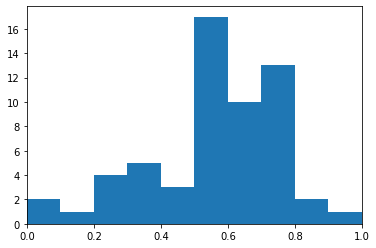

In [ ]:
plt.hist(fp_df['MatchFreq'])
plt.xlim(xmin=0,xmax=1)
plt.show()

In [ ]:
def evaluate_learner(X_train, X_test, y_train, y_test):
    '''
    Run multiple times with different algorithms to get an idea of the
    relative performance of each configuration.
    Returns a sequence of tuples containing:
        (title, expected values, actual values)
    for each learner.
    '''

    # Use a support vector machine for regression
    from sklearn.svm import SVR

    # Train using a radial basis function
    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    r_2 = svr.score(X_test, y_test)
    yield 'RBF Model ($R^2={:.3f}$)'.format(r_2), y_test, y_pred

    # Train using a linear kernel
    svr = SVR(kernel='linear')
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    r_2 = svr.score(X_test, y_test)
    yield 'Linear Model ($R^2={:.3f}$)'.format(r_2), y_test, y_pred

    # Train using a polynomial kernel
    svr = SVR(kernel='poly')
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    r_2 = svr.score(X_test, y_test)
    yield 'Polynomial Model ($R^2={:.3f}$)'.format(r_2), y_test, y_pred

    #Train using a sigmoidal kernel
    svr = SVR(kernel='sigmoid')
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    r_2 = svr.score(X_test, y_test)
    yield 'Sigmoid Model ($R^2={:.3f}$)'.format(r_2), y_test, y_pred


In [ ]:
# sc = StandardScaler()
# X_train_norm = sc.fit_transform(X_train)
# X_test_norm = sc.transform(X_test)

values = evaluate_learner(X_train, X_test, y_train, y_test)
for val in values:
  print(val)

0.23280562176166464


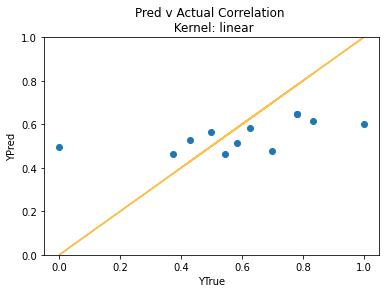

Mean squared error: 0.05
Coefficient of determination: 0.23
0.2534647945765993


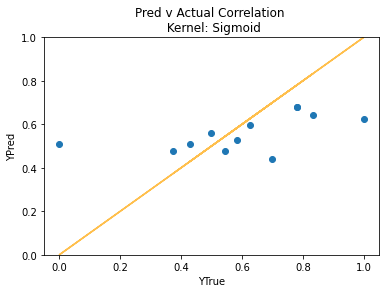

In [ ]:
#linear
lin_perf = []

kernel = 'linear'
svr = SVR(kernel=kernel)

clf = svr.fit(X_train, y_train)
y_pred_norm = clf.predict(X_test)
r = svr.score(X_test, y_test)
print(r)
#m, b = np.polyfit(y_test, y_pred_norm, 1)
plt.plot(y_test, y_test, color = 'orange', alpha = 0.7)
#print(f'{m:.2f}' + "x+" + f'{b:.2f}')
plt.scatter(y_test, y_pred_norm)
plt.ylabel('YPred')
plt.ylim(0,1)
plt.xlabel('YTrue')
plt.title ('Pred v Actual Correlation \n Kernel: ' + kernel)
plt.show()
import sklearn.metrics as metrics
plt.show()
plt.savefig('Pred v Actual Correlation linear_SVR_.png')
plt.close()

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_norm))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_norm))
lin_perf.append(r)
#sigmoid
sig_perf = []
kernel = 'Sigmoid'
svr = SVR(kernel='sigmoid')
clf = svr.fit(X_train, y_train)
y_pred_norm = clf.predict(X_test)
r = svr.score(X_test, y_test)
r_2 = r2_score(y_test, y_pred_norm)
print(r_2)
#m, b = np.polyfit(y_test, y_pred_norm, 1)
plt.plot(y_test, y_test, color = 'orange', alpha = 0.7)
#print(f'{m:.2f}' + "x+" + f'{b:.2f}')
plt.scatter(y_test, y_pred_norm)
plt.ylabel('YPred')
plt.ylim(0,1)
plt.xlabel('YTrue')
plt.title ('Pred v Actual Correlation \n Kernel: ' + kernel)
plt.savefig('Pred v Actual Correlation Sigmoid_SVR_.png')

plt.show()
# # sns.regplot(y_test, y_pred_norm)
# # print("Coefficients: \n", clf.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_norm))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_norm))
# sig_perf.append(r)
plt.close()


In [ ]:
import numpy as np

#calculate mean, standard deviation of list
np.std(lin_perf)
np.mean(lin_perf)
print( "Linear model std dev and mean: %.2f, %.2f " % (np.std(lin_perf), np.mean(lin_perf)))


np.std(sig_perf)
np.mean(sig_perf)
print( "Sigmoid model std dev and mean: %.2f, %.2f " % (np.std(sig_perf), np.mean(sig_perf)))

Linear model std dev and mean: 0.00, 0.37 
Sigmoid model std dev and mean: 0.00, 0.35 


# Modeling products

In [ ]:
# deprotect
libgen = oechem.OELibraryGen("[#6:1][N:2][#6:4](=[O:5])[O:6][C:7][#6:8][H:9]>>[#6:1][N:2]")
libgen.SetValenceCorrection(True)
#istream = oechem.oemolistream('AD_DEL16_Cycle_1_Diamines.sdf')
df = pd.read_csv('16.3_cyc1_Smiles.csv')
for oemol in df['SMILES']:
  mol = oechem.OEGraphMol()
  oemol = str(oemol)
  oemol1 = oechem.OEGraphMol()
  oechem.OESmilesToMol(oemol1,oemol)
  try:
    libgen.SetStartingMaterial(oemol1,0)
    i = 0
    for product in libgen.GetProducts():
        smi = oechem.OEMolToSmiles(product)
        smi = smi.replace(".c1ccc([c]c1)c2cccc[c]2","")
        smi = smi.replace("c1ccc([c]c1)c2cccc[c]2.","")
        oechem.OESmilesToMol(product, smi)
        print(smi)
        if i == 0:
          # oechem.OEAddSDData(product, "Monomer #", str(oechem.OEGetSDData(oemol, 'Monomer #')))
          # oechem.OEAddSDData(product, "Molecule Name", str(oechem.OEGetSDData(oemol, 'Molecule Name')))
          # oechem.OEAddSDData(product, "Dataset Name", str(oechem.OEGetSDData(oemol, 'Dataset Name')))
          oechem.OEWriteMolecule(ofs, product)
          i += 1
  except:
    oechem.OEWriteMolecule(ofs, oemol1)


[[ 8 54]
 [13 92]]
Accuracy: 0.5988023952095808
[[11 51]
 [10 95]]
Accuracy: 0.6347305389221557
[[13 49]
 [ 8 97]]
Accuracy: 0.6586826347305389
[[16 46]
 [ 9 96]]
Accuracy: 0.6706586826347305
[[21 41]
 [20 85]]
Accuracy: 0.6347305389221557
[[ 10  52]
 [  5 100]]
Accuracy: 0.6586826347305389
[[ 11  51]
 [  5 100]]
Accuracy: 0.6646706586826348
[[11 51]
 [ 7 98]]
Accuracy: 0.6526946107784432
[[11 51]
 [ 8 97]]
Accuracy: 0.6467065868263473


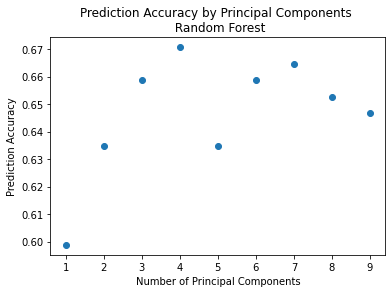

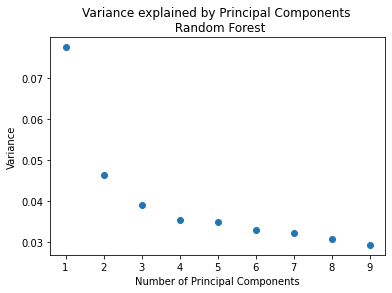

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fp_df.iloc[0:, 5:], fp_df['Match?'], test_size= 0.2, random_state = 1 )
#for loop to find  best conditions for PCA in random forest

score_lst = []
PCA_comps = []
for i in range(1,10):
  X_train_norm = sc.fit_transform(X_train)
  X_test_norm = sc.transform(X_test)



  pca = PCA(n_components = i)
  X_train_norm = pca.fit_transform(X_train_norm)
  X_test_norm = pca.transform(X_test_norm)



  classifier = RandomForestClassifier(max_depth=3, random_state=1)
  classifier.fit(X_train_norm, y_train)

  # Predicting the Test set results
  y_pred_norm = classifier.predict(X_test_norm)
  cm = confusion_matrix(y_test, y_pred_norm)
  explained_variance = pca.explained_variance_ratio_

  PCA_comps.append(i)
  score_lst.append(accuracy_score(y_test, y_pred_norm))
  print(cm)
  print('Accuracy: ' + str(accuracy_score(y_test, y_pred_norm)))


# plot accuracy as function of PC's
plt.scatter(PCA_comps, score_lst)
plt.title('Prediction Accuracy by Principal Components \n Random Forest')
plt.xlabel('Number of Principal Components')
plt.ylabel('Prediction Accuracy')
plt.savefig('PredAccuracy_RFwPCA.svg')
plt.show()


# plot variance explained by num PC's
plt.scatter(PCA_comps, explained_variance)
plt.title('Variance explained by Principal Components \n Random Forest')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.savefig('VariancebyPC_RFwPCA.svg')
plt.show()